![Adversarial Inverse Reinforcement Learning for Market Making](.images/title_image.png)

This notebook contains the code for the paper [*Adversarial Inverse Reinforcement Learning for Market Making* (2024)](https://dl.acm.org/doi/pdf/10.1145/3677052.3698641) by Juraj Zelman (Richfox Capital &  ETH Zürich), Martin Stefanik (Richfox Capital &  ETH Zürich), Moritz Weiß (ETH Zürich) and Prof. Dr. Josef Teichmann (ETH Zürich). The paper was published and presented at the [5th ACM International Conference on AI in Finance (ICAIF ’24)](https://ai-finance.org/). The links of both affiliations: [Richfox Capital](https://www.richfox.com/) and [ETH Zürich (Dept. of Mathematics)](https://math.ethz.ch/).

In the following sections, we demonstrate a pipeline for training of the [Adversarial Inverse Reinforcement Learning agent](https://imitation.readthedocs.io/en/latest/algorithms/airl.html) implemented in the [imitation](https://imitation.readthedocs.io/en/latest/index.html) package. The package is described in the paper [Imitation: Clean imitation learning implementations - Gleave et al. (2022)](https://arxiv.org/pdf/2211.11972). The goal is to learn the reward function of the expert policy by training of the discriminator network and the agent policy network by the Proximal Policy Optimization algorithm introduced in the paper [Proximal Policy Optimization Algorithms - Schulman et al. (2017)](https://arxiv.org/abs/1707.06347). For the PPO policy, we use the implementation from the [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/) library. This library is described in more detail in the paper [Stable-baselines3: Reliable reinforcement learning implementations - Raffin et al. (2021)](https://www.jmlr.org/papers/volume22/20-1364/20-1364.pdf). 

This notebook is structured as follows:
- [**Section 1: Limit order book data preprocessing**](#section-1-limit-order-book-data-preprocessing) - In the first section, the pricing data are queried, cleaned and additionally preprocessed for the training of the market making agent and backtesting.
- [**Section 2: Pre-generate expert trajectories**](#section-2-pre-generate-expert-trajectories) - In this section, we initialize our custom limit order book environment and pre-generate expert trajectories for the training of the adversarial inverse reinforcement learning (AIRL) agent. This is to save computational resources during the training of the AIRL agent.
- [**Section 3: Training of the AIRL agent**](#section-3-training-of-the-airl-agent) - This section contains the full training pipeline of the adversarial inverse reinforcement learning agent (hyperparameters, initialization, training and saving).
- [**Section 4: Evaluation of the AIRL agent**](#section-4-evaluation-of-the-airl-agent) - Here we display more detailed evaluation of the trained AIRL agent (discriminator & generator statistics, mean episode rewards, etc.).
- [**Section 5: Backtesting pipeline**](#section-5-backtesting-pipeline) - In this section, we demonstrate the backtesting pipeline for the pure market making strategy and the AIRL market making strategy. We compare the performance of both strategies in the out-of-sample period over 50 random realizations.
- [**Section 6: Visualization of backtests**](#section-6-visualization-of-backtests) - In Section 6, we visualize the backtest results of the pure market making strategy and the AIRL market making strategy. We compare the performance of both strategies in the out-of-sample period over 50 random realizations.
- [**Section 7: Appendix (data analysis)**](#section-7-appendix-data-analysis) - Lastly, we provide additional data analysis of the pricing and trades data used in the training and backtesting of the market making strategies.

Firstly, let's start by importing the necessary libraries and with general setup.

In [3]:
import os
import pickle
import time
from datetime import datetime

import gymnasium as gym
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as th
from imitation.algorithms.adversarial.airl import AIRL
from imitation.data import rollout, serialize
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util.util import make_vec_env
from matplotlib.dates import DateFormatter
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecCheckNan
from stable_baselines3.ppo import MlpPolicy
from tqdm import tqdm

from src.data import download_data, get_list_of_dates_between
from src.lob.backtest_metrics import drawdowns
from src.lob.commissions import BitCommissions
from src.lob.exchange import Exchange
from src.lob.plots import (
    make_drawdown_plot,
    make_plot,
    plot_comparison,
    plot_multi_results,
    set_plot_style,
    visualize_backtest,
)
from src.lob.traders import PureMarketMaker, RLMarketMaker
from src.lob.utils import get_lot_size, get_tick_size
from src.rl.environments import LimitOrderBookGym
from src.rl.experts import ExpertPolicy, RandomPolicy
from src.rl.plotting import visualize_airl_train_stats
from src.rl.rewards import NegativeRewardNet
from src.rl.utils import load_model, save_model, send_notification

In [4]:
# Set style of plots
set_plot_style()

# Set strict error checking
th.autograd.set_detect_anomaly(True)
np.seterr(all="raise")

# Set device to GPU if available
DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [5]:
# Set (relative) paths to directories
PATH = "data/pricing/"
PATH_MODELS = "data/models"
PATH_ROLLOUTS = "data/rollouts/"
PATH_VOL_DISTR = "data/volume_distributions/"
PATH_AUTOMATED_BACKTESTS = "data/automated_backtests"
PATH_FIGURES = "figures/"

# Ensure directories exist
os.makedirs(PATH, exist_ok=True)
os.makedirs(PATH_MODELS, exist_ok=True)
os.makedirs(PATH_ROLLOUTS, exist_ok=True)
os.makedirs(PATH_VOL_DISTR, exist_ok=True)
os.makedirs(PATH_AUTOMATED_BACKTESTS, exist_ok=True)
os.makedirs(PATH_FIGURES, exist_ok=True)

In [6]:
# Seed for the random generator
# SEED = 1
# SEED = 2
# SEED = 3
# SEED = 4
SEED = 5

In [7]:
# Set parameters for the limit order book environment
EXCHANGE = "BIT.COM"  # Exchange name
SYMBOL = "SOL-USDT"  # Cryptocurrency pair
TICK_SIZE = get_tick_size(EXCHANGE)  # Tick size of the limit order book
LOT_SIZE = get_lot_size(EXCHANGE)  # Lot size of the limit order book
DEPTH = 20  # Depth of the data to load to the limit order book (max 20)
OB_PREFIX = f"{EXCHANGE}_{SYMBOL}_order_book"  # Prefix for the order book data
TRADES_PREFIX = f"{EXCHANGE}_{SYMBOL}_trades"  # Prefix for the trades data
RNG = np.random.default_rng(seed=SEED)  # Random number generator
WIN = 0  # Window size for the features computation
MAX_STEPS = None  # Maximum number of steps in an episode
LATENCY_COMP_PARAMS = {
    0: {"prob": 0.9, "divisor": 1},
    1: {"prob": 0.9, "divisor": 1},
    2: {"prob": 0.9, "divisor": 1},
    3: {"prob": 0.9, "divisor": 1},
}  # Latency compensation parameters for stochastic backtest

In [8]:
# Set dates and timestamps
DATE_START = datetime(2023, 9, 1)
DATE_END_TRAIN = datetime(2023, 9, 10)
DATE_START_TEST = datetime(2023, 9, 11)
DATE_END = datetime(2023, 9, 13)
TS_START = pd.Timestamp("2023-09-01 00:00:00")
TS_END_TRAIN = pd.Timestamp("2023-09-10 23:59:59")
TS_START_TEST = pd.Timestamp("2023-09-11 00:00:00")
TS_END = pd.Timestamp("2023-09-13 23:59:59")

In [9]:
# Set printing/plotting options
PRINT = False  # Enable/disable long print outputs
SAVE_FIG = False  # Enable/disable saving of figures
FIG_SIZE = (14, 5)  # Set size of figures
PLOT_TITLE = True  # Enable/disable plot titles

# Set custom color codes
COLOR_GREEN, COLOR_RED = "#13961A", "#EB5C14"

# Section 1: Limit order book data preprocessing

In this first section, we download and preprocess the limit order book and trades data for the training and testing of the AIRL market making agent.

<font color='#EB5C14'>**Remark:**</font> As discussed in the paper, for this public research and demonstration of the AIRL algorithm we get the data from the [Crypto Lake](https://crypto-lake.com/) data provider. For the SOL-USD there is data available from the smaller crypto exchange BIT.COM. As you will see, the strategies are limited in capacity. Nevertheless, since the focus of the paper was the demonstration of the new AIRL approach, they are enough to demonstrate our training pipeline. For a real-world market making application, more sophisticated data preprocessing, data cleaning and live exchange analysis (e.g. real exchange volumes, detection of fake trades, latency measurements, API limits,  etc.) would be necessary and such analysis was beyond the scope of the paper.

### 1.1. Data querying

Firstly, the limit order book and trade data are downloaded from the [Crypto Lake](https://crypto-lake.com/) data provider.

<font color='#EB5C14'>**Remark:**</font> In order to download the data, it is required to have an active [subscription](https://crypto-lake.com/subscribe/) and the associated AWS credentials file.

In [10]:
# Generate a list of dates to download
dates = get_list_of_dates_between(DATE_START, DATE_END)

In [ ]:
# Query data
for date in tqdm(dates):
    download_data(date, SYMBOL, EXCHANGE, "book", PATH)  # LOB data
    download_data(date, SYMBOL, EXCHANGE, "trades", PATH)  # Trade data

### 1.2. Visualize bid-ask prices

In this subsection, we visualize the bid-ask prices for different limit order book levels. As can be seen from the visualizations below, there are multiple timestamps with wide quoted spreads.

These timestamps are filtered out from the dataset in the next subsection so that the market maker does not profit from these (to be safe we choose the assumption that these were not capturable). This assumption can potentially only worsen the market maker's performance in our backtests. A more detailed analysis would be needed to determine whether such spreads could be captured by the market maker in live trading but this is beyond the scope of the paper.

In [14]:
def load_and_join_dataframes(
    dates: list[datetime],
    path: str,
    prefix: str = OB_PREFIX,
    original: bool = False,
) -> pd.DataFrame:
    """
    Load and join order book dataframes for given dates.

    Args:
        dates: List of dates to process.
        path: Path to the directory containing the files.
        prefix: Prefix of the files to load.
        original: Whether to load the original or the cleaned data.

    Returns:
        pd.DataFrame: A single joined and sorted dataframe.
    """
    # Load all dataframes
    joined_dfs = []
    for date in dates:
        postfix = "_original" if original else ""
        file_name = f"{OB_PREFIX}_{date.strftime('%Y_%m_%d')}{postfix}.parquet"
        df = pd.read_parquet(os.path.join(path, file_name))
        joined_dfs.append(df)

    # Concatenate all dataframes and sort by index
    df_joined = pd.concat(joined_dfs).sort_index()

    return df_joined

In [15]:
# Load all dataframes
dates = get_list_of_dates_between(DATE_START, DATE_END)
df_joined = load_and_join_dataframes(dates, PATH, original=True)

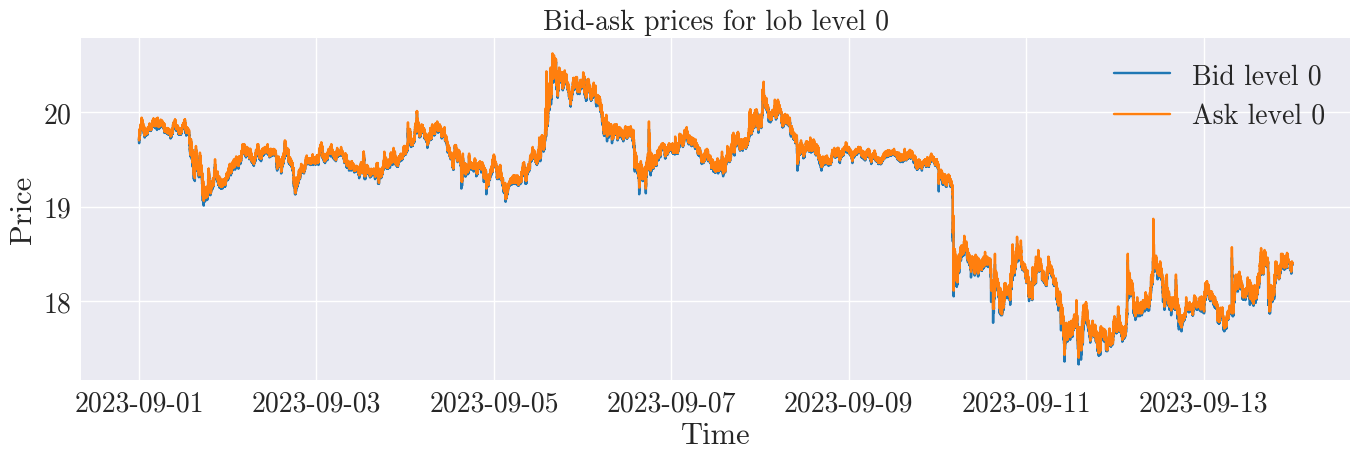

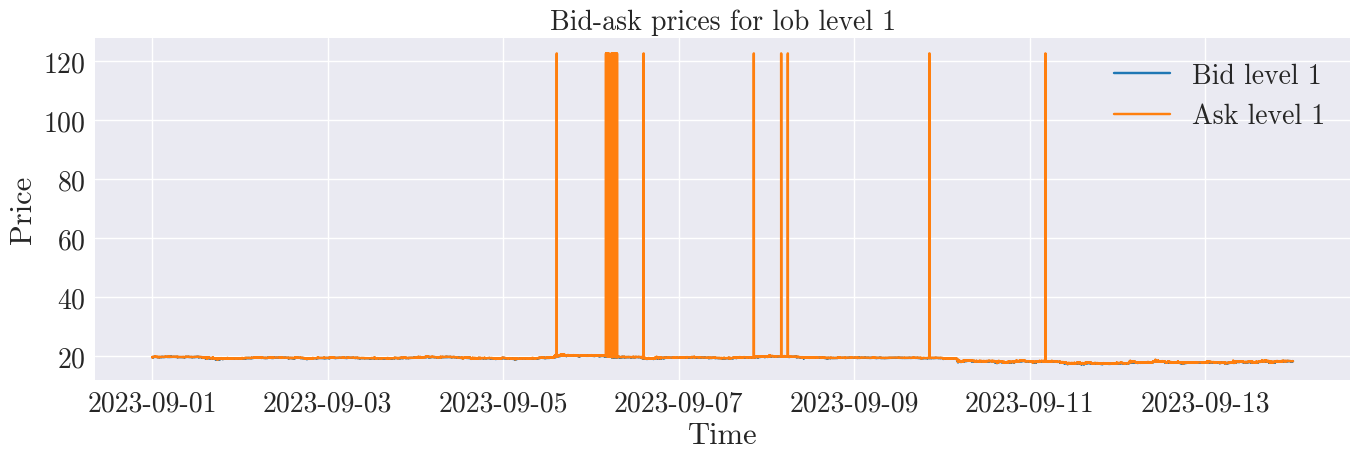

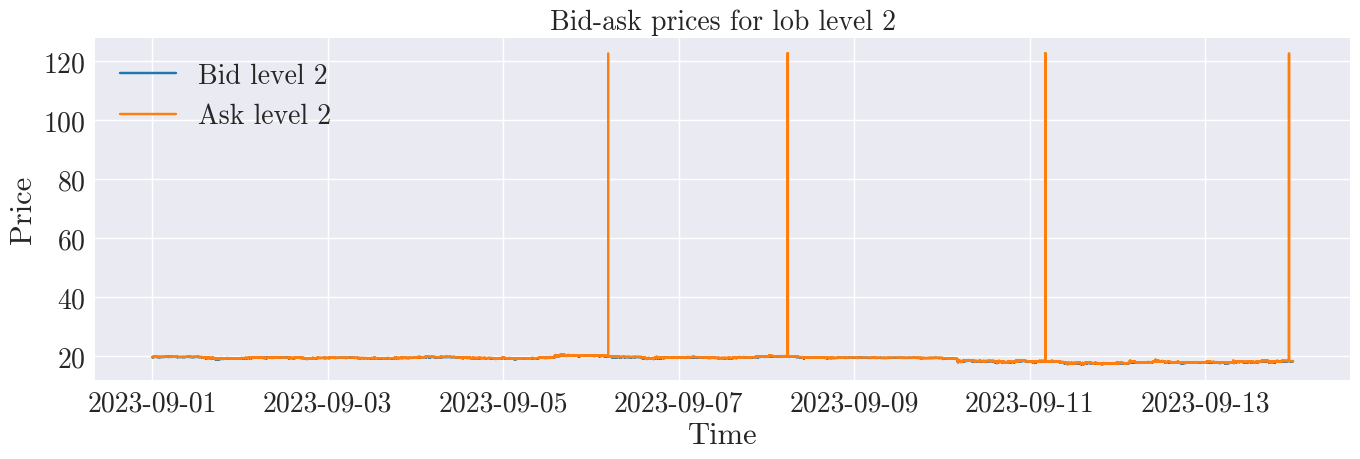

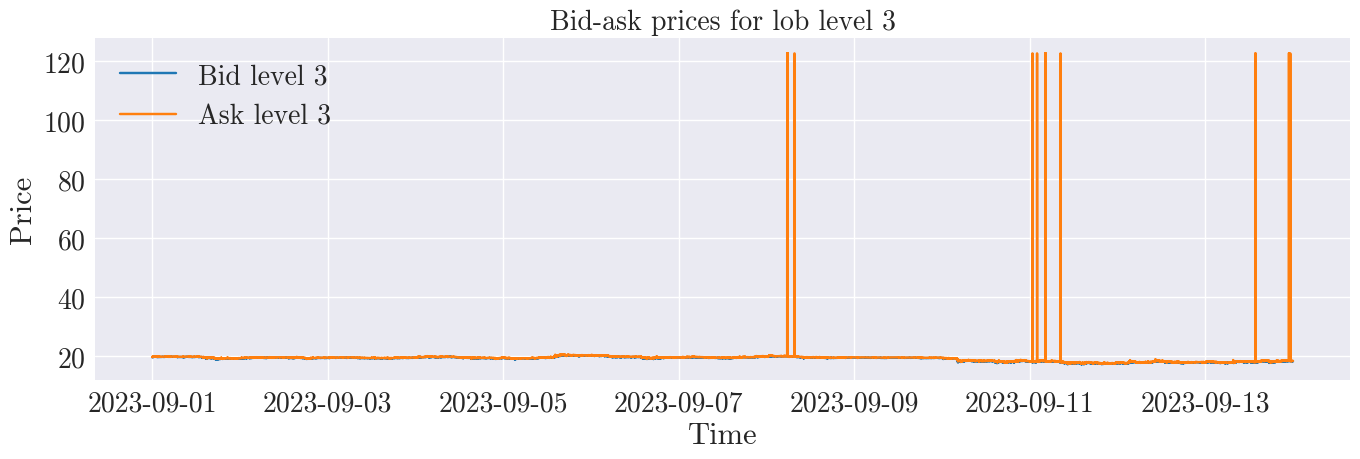

In [16]:
# Visualize bid-ask prices for each limit order book level
for level in range(4):
    fig = plt.figure(figsize=FIG_SIZE)
    plt.plot(df_joined[f"bid_{level}_price"], label=f"Bid level {level}")
    plt.plot(df_joined[f"ask_{level}_price"], label=f"Ask level {level}")
    plt.title(f"Bid-ask prices for lob level {level}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 1.3. Data cleaning

In the following, we filter out the timestamps with the outlier spreads visualized in the previous section. The number of timestamps filtered for each day is printed below.

Since the focus of the paper is on the market making strategy quoting limit orders, this assumption does not improve the backtest performance as the market making agent does not have the possibility to quote limit orders at the prices with these large spreads.

In [17]:
# Define the cleaning threshold
THRESHOLD_CLEANING = 30

In [18]:
# Initialize an empty list to collect cleaned dataframes
cleaned_dfs = []

for date in dates:
    # Load the dataframe
    file_name = f"{OB_PREFIX}_{date.strftime('%Y_%m_%d')}_original.parquet"
    df = pd.read_parquet(os.path.join(PATH, file_name))

    # Calculate rows to be filtered
    filters = (
        (df["ask_0_price"] > THRESHOLD_CLEANING)
        | (df["ask_1_price"] > THRESHOLD_CLEANING)
        | (df["ask_2_price"] > THRESHOLD_CLEANING)
    )
    filtered_count = df[filters].shape[0]
    print(
        f"Date: {date} - Rows to be filtered: {filtered_count} "
        f"out of {df.shape[0]} ({filtered_count / df.shape[0] * 100:.2f}%)"
    )

    # Filter out rows with prices exceeding threshold
    clean_df = df[
        (df["ask_0_price"] < THRESHOLD_CLEANING)
        & (df["ask_1_price"] < THRESHOLD_CLEANING)
        & (df["ask_2_price"] < THRESHOLD_CLEANING)
        & (df["ask_3_price"] < THRESHOLD_CLEANING)
    ]

    # Save the cleaned dataframe
    new_file_name = f"{OB_PREFIX}_{date.strftime('%Y_%m_%d')}.parquet"
    clean_df.to_parquet(os.path.join(PATH, new_file_name))

    # Append cleaned dataframe to the list for later concatenation
    cleaned_dfs.append(clean_df)

# Concatenate all cleaned dataframes and sort by index
df_joined = pd.concat(cleaned_dfs).sort_index()

Date: 2023-09-01 00:00:00 - Rows to be filtered: 0 out of 7014 (0.00%)
Date: 2023-09-02 00:00:00 - Rows to be filtered: 0 out of 7577 (0.00%)
Date: 2023-09-03 00:00:00 - Rows to be filtered: 0 out of 6754 (0.00%)
Date: 2023-09-04 00:00:00 - Rows to be filtered: 0 out of 7383 (0.00%)
Date: 2023-09-05 00:00:00 - Rows to be filtered: 1 out of 8767 (0.01%)
Date: 2023-09-06 00:00:00 - Rows to be filtered: 39 out of 8149 (0.48%)
Date: 2023-09-07 00:00:00 - Rows to be filtered: 3 out of 7168 (0.04%)
Date: 2023-09-08 00:00:00 - Rows to be filtered: 231 out of 9118 (2.53%)
Date: 2023-09-09 00:00:00 - Rows to be filtered: 9 out of 6144 (0.15%)
Date: 2023-09-10 00:00:00 - Rows to be filtered: 0 out of 8583 (0.00%)
Date: 2023-09-11 00:00:00 - Rows to be filtered: 39 out of 11291 (0.35%)
Date: 2023-09-12 00:00:00 - Rows to be filtered: 0 out of 10089 (0.00%)
Date: 2023-09-13 00:00:00 - Rows to be filtered: 423 out of 12495 (3.39%)


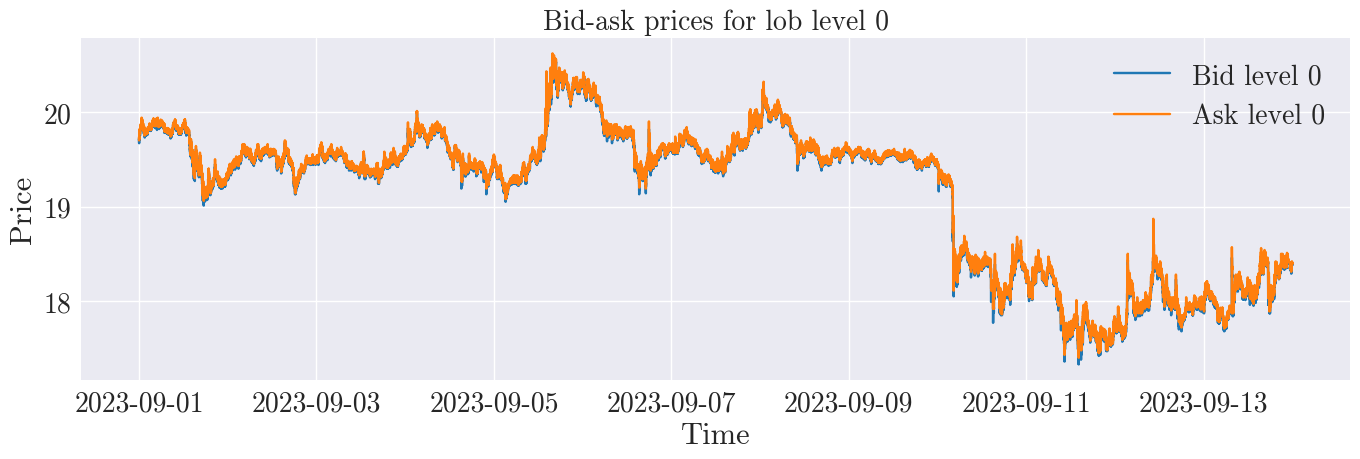

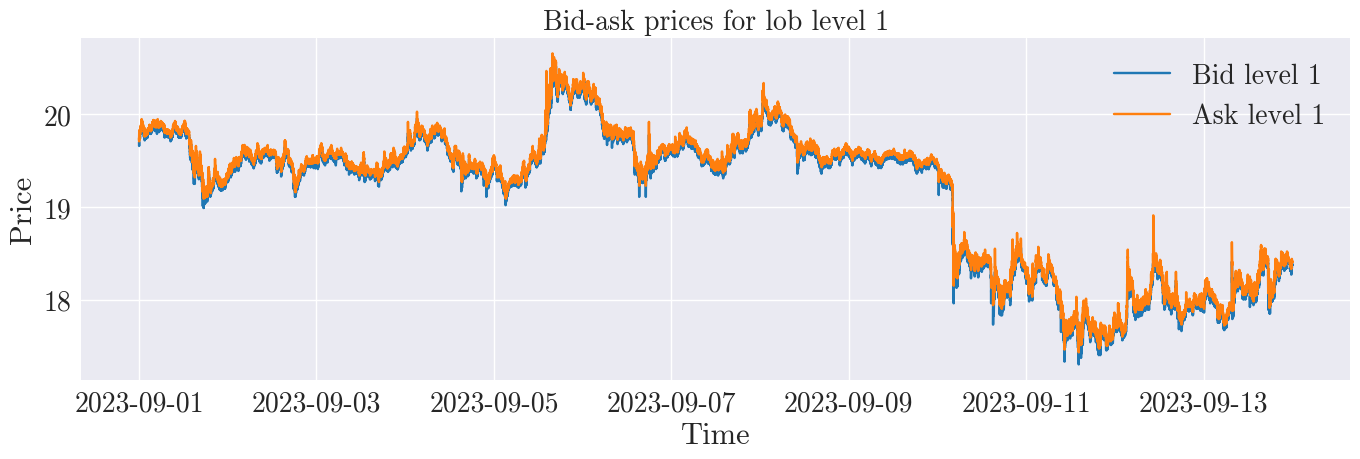

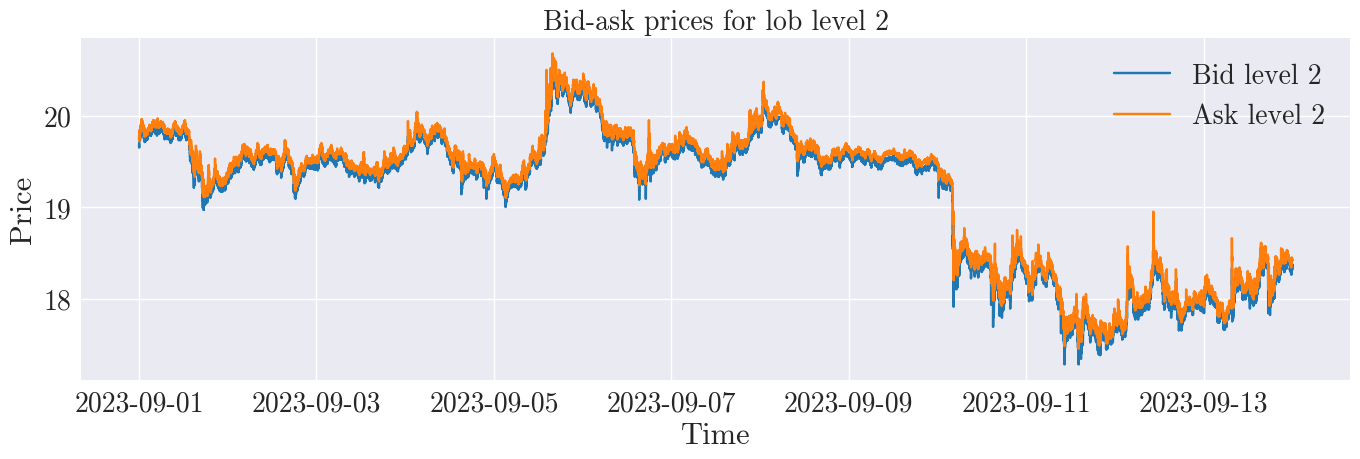

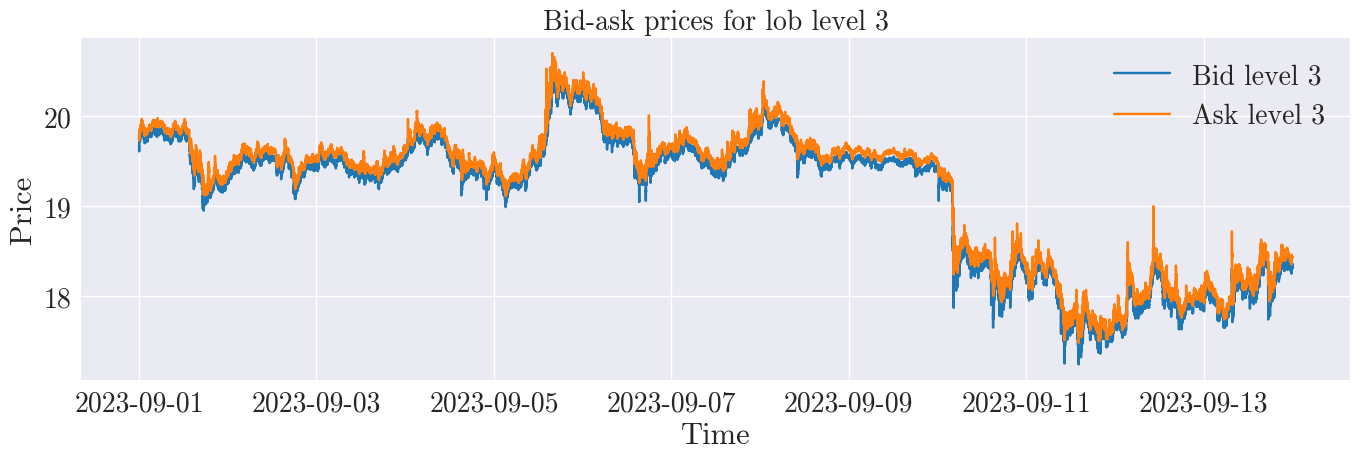

In [19]:
# Visualize bid-ask prices for each limit order book level (after cleaning)
for level in range(4):
    fig = plt.figure(figsize=(14, 5))
    plt.plot(df_joined[f"bid_{level}_price"], label=f"Bid level {level}")
    plt.plot(df_joined[f"ask_{level}_price"], label=f"Ask level {level}")
    plt.title(f"Bid-ask prices for lob level {level}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

The outlier spreads are now removed from the data and the cleaned data are used for the training of the market making agent.

### 1.3. Generate volume distributions

Here, we generate empirical volume distributions at each limit order book level. As described in the paper, these empirical volume distributions are used in the stochastic backtest simulator to sample volumes of penalizing front-running orders which worsen order book priority of the market making agent's orders.

In [20]:
# Generate a list of dates
dates = get_list_of_dates_between(DATE_START, DATE_END_TRAIN)

# Create a single joined dataframe with order book data
df_joined = load_and_join_dataframes(dates, PATH)

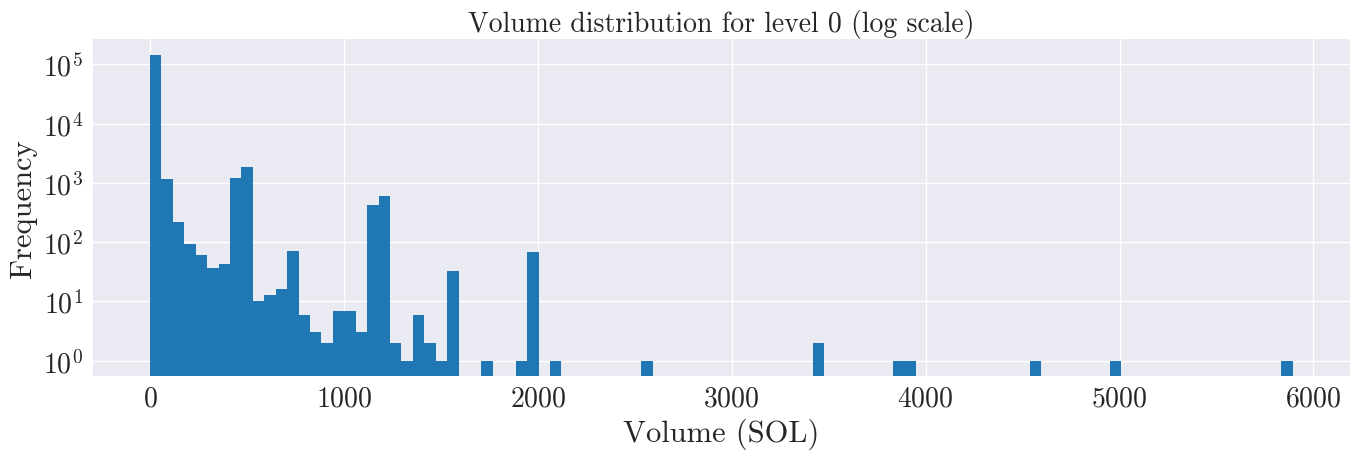

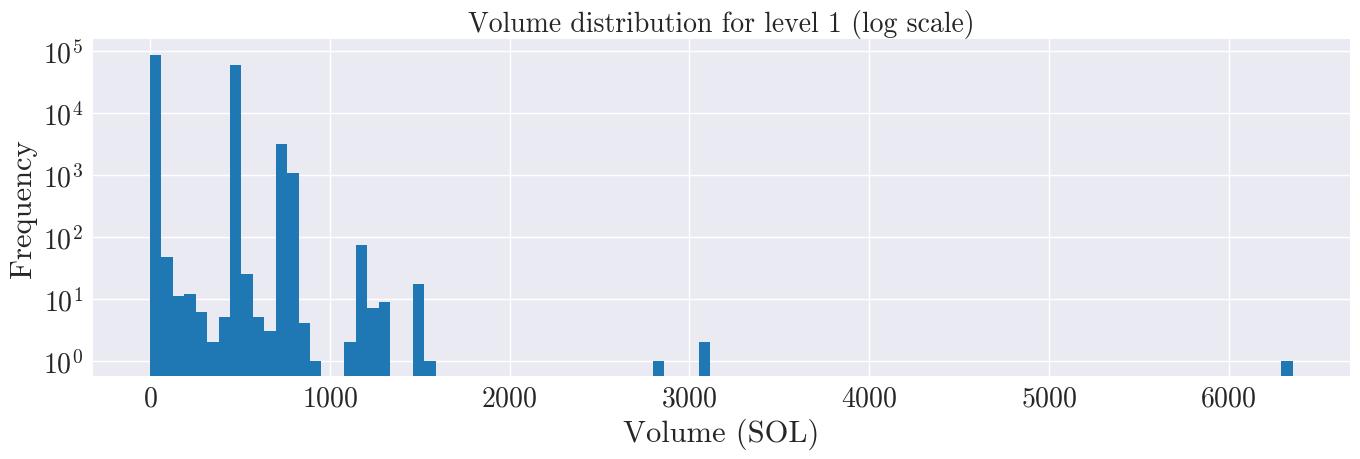

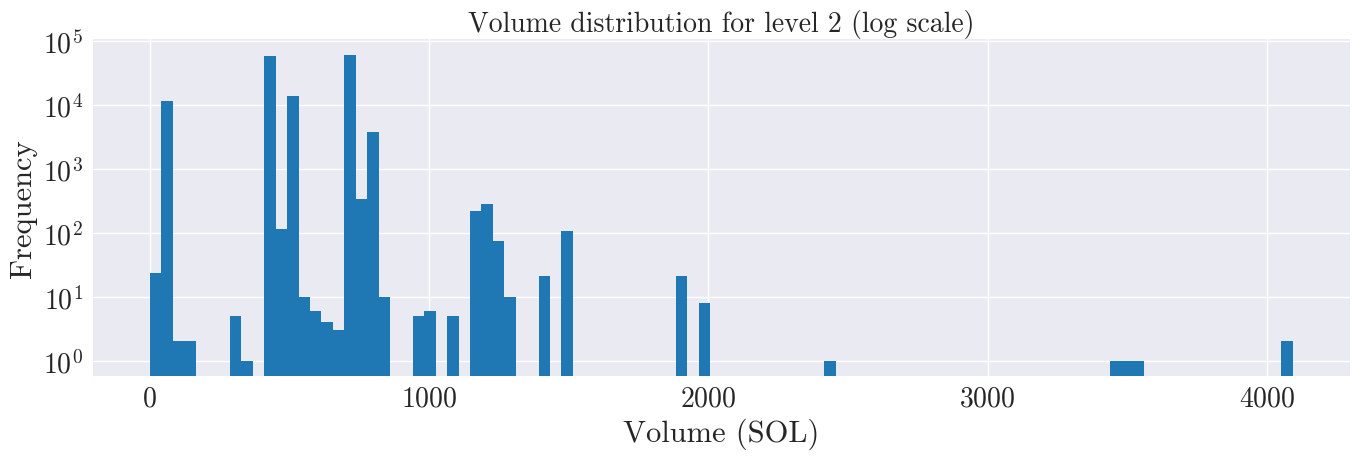

In [21]:
# Visualize volume distribution for each limit order book level
for level in range(3):
    # Join the bid and ask volumes
    vols_level = list(df_joined[f"bid_{level}_size"].values) + list(
        df_joined[f"ask_{level}_size"].values
    )

    # Visualize the volume distribution
    fig = plt.figure(figsize=FIG_SIZE)
    plt.hist(vols_level, bins=100, log=True)
    plt.xlabel("Volume (SOL)")
    plt.ylabel("Frequency")
    plt.title(f"Volume distribution for level {level} (log scale)")
    plt.tight_layout()
    plt.show()

In [22]:
# Generate and save volume distributions. These distributions are later
# loaded and sampled from in stochastical backtests.
for level in range(3):
    # Join bid and ask volumes
    vols_level = pd.Series(
        list(df_joined[f"bid_{level}_size"].values)
        + list(df_joined[f"ask_{level}_size"].values)
    ).dropna()

    # Save the volume distribution
    file_path = os.path.join(PATH_VOL_DISTR, f"volumes_level_{level}.pkl")
    vols_level.to_pickle(file_path)

# Section 2: Pre-generate expert trajectories

In the second section, we pre-generate the expert trajectories (rollouts) using the previously downloaded limit order book data. The expert trajectories are generated by simulating the expert-like market making agent's actions in the backtest simulator. These expert trajectories are later used in the adversarial inverse reinforcement learning algorithm to train the discriminator (or reward neural network) for distinguishing the expert trajectories from the adversarial agent's trajectories.

### 2.1. Register a custom vectorized environment

Firstly, we need to load and register our custom limit order book environment as a custom gym vectorized environment. This is necessary for the [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/) library to work with the environment. This environment was implemented as a part of the paper and can be found in the [`src/lob`](./src/lob/) module and [`src/rl/environments.py`](./src/rl/environments.py) file.

In [23]:
# Set parameters
max_steps = 300  # Maximum number of steps in a single episode
deterministic = False  # Indicates whether to use a deterministic environment
logging = False  # Indicates whether to log events
ts_save = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Ts for model saving
latency_comp_params = {}  # Parameters for the stochastic backtest
traders = {}  # Dictionary of traders

print("Timestamp for saving: ", ts_save)

Timestamp for saving:  2024-11-11_23-42-12


In [24]:
# Set parameters for the RL agent
rl_trader_id = "RLMarketMaker"
com_model = BitCommissions(tier=5)
volume = 100

# Initialize the trader
trader = RLMarketMaker(
    id=rl_trader_id,
    com_model=com_model,
    volume=volume,
)
traders[rl_trader_id] = trader

# Write a description of the experiment
description = "RL market maker simulation."

In [25]:
# Set parameters for the limit order book environment
ID = "LimitOrderBookGym-v1"
ENTRY_POINT = LimitOrderBookGym
KWARGS = {
    "exchange_name": EXCHANGE,
    "symbol_name": SYMBOL,
    "tick_size": TICK_SIZE,
    "lot_size": LOT_SIZE,
    "depth": DEPTH,
    "traders": traders,
    "max_steps": max_steps,
    "ts_start": TS_START,
    "ts_end": TS_END_TRAIN,
    "deterministic": deterministic,
    "win": WIN,
    "path": PATH,
    "path_vol_distr": PATH_VOL_DISTR,
    "rl_trader_id": rl_trader_id,
    "latency_comp_params": latency_comp_params,
    "logging": logging,
    "ts_save": ts_save,
    "description": description,
    "rng": RNG,
}

# Register the environment
gym.envs.register(
    id=ID,
    entry_point=ENTRY_POINT,
    kwargs=KWARGS,
    max_episode_steps=max_steps,
)

# Create the environment
env = Monitor(gym.make(ID))

# Save the saving ts
ts_save = env.unwrapped.exchange.ts_save

In [26]:
# Initialize the vectorized environment
venv = make_vec_env(
    ID,
    rng=RNG,
    n_envs=1,
    post_wrappers=[
        lambda env, _: RolloutInfoWrapper(env)
    ],  # needed for computing rollouts later
    parallel=False,
)
venv = VecCheckNan(venv, raise_exception=True)  # Check for NaN observations
venv.reset()

array([[ 0.        , -0.47486764, -0.55422354, -0.4666505 ,  0.47486764,
         0.38615406,  0.33866906,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]], dtype=float32)

### 2.2. Generate trajectories (rollouts) with random and expert policies

Next, we define an expert policy that will be used as a target for the adversarial agent. We use this expert policy to generate the expert trajectories for the AIRL algorithm. These trajectories are saved to the `data/rollouts` directory and loaded before training to save time in the training process. Alternatively, you can also generate these during the AIRL training process but this will take more time rather than loading and sampling from the pre-generated expert trajectories.

In [27]:
# Set parameters for the rollout
min_timesteps = None
min_episodes = 1

# Rollout the environment with a random policy
rollouts = rollout.rollout(
    None,  # Random policy
    venv,
    sample_until=rollout.make_sample_until(
        min_timesteps=min_timesteps, min_episodes=min_episodes
    ),
    rng=RNG,
)

# Print the first rollout
if PRINT:
    for i in range(len(rollouts[0].obs) - 1):
        print("Observation: ", rollouts[0].obs[i])
        print("Action: ", rollouts[0].acts[i])
        print()

In [28]:
# Initialize the random policy
random_policy = RandomPolicy(venv.action_space)

# Evaluate the random policy
reward_random_policy, _ = evaluate_policy(
    random_policy, env, 1, return_episode_rewards=True
)
print("Reward of the random policy")
print("---------------------------")
print("Reward: ", np.mean(reward_random_policy))
print("Std:    ", np.std(reward_random_policy))

Reward of the random policy
---------------------------
Reward:  14.0
Std:     0.0


In [29]:
# Initialize the expert policy
expert = ExpertPolicy()

# Set parameters for the rollout
min_timesteps = None
min_episodes = 1

# Rollout the environment with the expert policy
rollouts = rollout.rollout(
    expert.predict,
    venv,
    sample_until=rollout.make_sample_until(
        min_timesteps=min_timesteps, min_episodes=min_episodes
    ),
    rng=RNG,
)

# Print the first rollout
if PRINT:
    for i in range(len(rollouts[0].obs) - 1):
        state, act = rollouts[0].obs[i][0], rollouts[0].acts[i]
        print(f"State 0: {state: .3f} --> Action: {act}")

In [30]:
# Flatten trajectories into transitions
transitions = rollout.flatten_trajectories(rollouts)
if PRINT:
    print("Transitions: ", transitions)

In [31]:
# Evaluate the expert
reward_expert_policy, _ = evaluate_policy(
    expert, venv, 1, return_episode_rewards=True
)
print("Perfect reward of the expert policy")
print("-----------------------------------")
print("Reward: ", np.mean(reward_expert_policy))
print("Std:    ", np.std(reward_expert_policy))

Perfect reward of the expert policy
-----------------------------------
Reward:  300.0
Std:     0.0


In [32]:
# Generate or load a presaved sample of expert trajectories.
# These rollouts are later used to train the AIRL agent, in particular they are
# used for training of the discriminator.
rollouts_file = os.path.join(PATH_ROLLOUTS, "rollouts.pkl")

# If the presaved rollouts file exists, load the rollouts
if os.path.exists(rollouts_file):
    rollouts = serialize.load(rollouts_file)

# Else, generate the rollouts and save them for future use
else:
    # Set the parameters for the rollout
    min_timesteps = 45000 * 3 + 4500
    min_episodes = None

    # Rollout the environment with the expert policy
    print("Generating rollouts... (Might take around 15 minutes.)")
    rollouts = rollout.rollout(
        expert.predict,
        venv,
        sample_until=rollout.make_sample_until(
            min_timesteps=min_timesteps, min_episodes=min_episodes
        ),
        rng=RNG,
    )

    # Ensure the directory exists and save the rollouts
    serialize.save(rollouts_file, rollouts)

# Print the first rollout
if PRINT:
    for i in range(len(rollouts[0].obs) - 1):
        print("Observation: ", rollouts[0].obs[i])
        print("Action: ", rollouts[0].acts[i])
        print()

The saved expert trajectories can be found in the [`data/rollouts`](./data/rollouts) directory.

# Section 3: Training of the AIRL agent

This section demonstrates a pipeline for training of the [Adversarial Inverse Reinforcement Learning agent](https://imitation.readthedocs.io/en/latest/algorithms/airl.html) implemented in the [imitation](https://imitation.readthedocs.io/en/latest/index.html) package described in the paper [Imitation: Clean imitation learning implementations - Gleave et al. (2022)](https://arxiv.org/pdf/2211.11972). The goal is to learn the reward function of the expert policy by training of the discriminator network and the agent policy network ([PPO](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) from the paper [Proximal Policy Optimization Algorithms - Schulman et al. (2017)](https://arxiv.org/abs/1707.06347)). We use the implementation from the [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/) library described in the paper [Stable-baselines3: Reliable reinforcement learning implementations - Raffin et al. (2021)](https://www.jmlr.org/papers/volume22/20-1364/20-1364.pdf). 

### 3.1. Initialize the AIRL agent

In this subsection, we set hyperparameters for the [PPO algorithm](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) and the AIRL discriminator ([reward neural network](https://imitation.readthedocs.io/en/latest/main-concepts/reward_networks.html)).

In [33]:
# Set parameters for the PPO algorithm (generator)
learning_rate = 0.001  # Learning rate, can be a function of progress
batch_size = 60  # Mini batch size for each gradient update
n_epochs = 10  # N of epochs when optimizing the surrogate loss

gamma = 0.5  # Discount factor, focus on the recent rewards
gae_lambda = 0  # Generalized advantage estimation
clip_range = 0.1  # Clipping parameter
ent_coef = 0.01  # Entropy coefficient for the loss calculation
vf_coef = 0.5  # Value function coef. for the loss calculation
max_grad_norm = 0.5  # The maximum value for the gradient clipping

verbose = 0  # Verbosity level: 0 no output, 1 info, 2 debug
normalize_advantage = True  # Whether to normalize or not the advantage

clip_range_vf = None  # Clip for the value function
use_sde = False  # Use State Dependent Exploration
sde_sample_freq = -1  # SDE - noise matrix frequency (-1 = disable)

In [34]:
# Set parameters for the (negative) reward net
use_state = True  # Whether to use current state in the reward
use_action = True  # Whether to use current action in the reward
use_next_state = False  # Whether to use next state in the reward
use_done = False  # Whether to use done flag in the reward

In [35]:
# Set parameters for the AIRL trainer
gen_replay_buffer_capacity = None
allow_variable_horizon = True

disc_opt_kwargs = {
    "lr": 0.001,
}
policy_kwargs = {"use_expln": True}  # Fixing an issue with NaNs

<font color='#EB5C14'>**Warning:**</font> Be careful when updating the settings below. When changing them, use the multiples of episode length (otherwise you might run into unexpected issues with variable horizons during training).

In [36]:
# Set the number of timesteps, batch size and number of disc updates

# Total number of timesteps in the whole training
total_timesteps = 3000 * 600

# Generator
gen_train_timesteps = 3000  # N steps in the environment per one round
n_steps = gen_train_timesteps

# Discriminator batches
demo_minibatch_size = 60  # N samples in minibatch for one discrim. update
demo_batch_size = 300 * 10  # N samples in the batch of expert data (batch)
n_disc_updates_per_round = 4  # N discriminator updates per one round

In [37]:
# Initialize the learner PPO policy (generator)
learner = PPO(
    env=venv,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=SEED,
    device=DEVICE,
)

In the following, we initialize the custom reward neural network as described in the paper. The neural network implementation can be found in the [`src/rl/rewards.py`](./src/rl/rewards.py) file.

In [38]:
# Initialize the custom reward network (discriminator)
reward_net = NegativeRewardNet(
    observation_space=venv.observation_space,
    action_space=venv.action_space,
    use_state=use_state,
    use_action=use_action,
    use_next_state=use_next_state,
    use_done=use_done,
)

In [39]:
# Initialize the AIRL trainer
airl_trainer = AIRL(
    demonstrations=rollouts,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


In [40]:
# Evaluate the PPO policy before training
venv.seed(SEED)
learner_rewards_before_training, _ = evaluate_policy(
    learner, venv, 1, return_episode_rewards=True
)
print("Reward of the learner policy before training")
print("--------------------------------------------")
print("Mean: ", np.mean(learner_rewards_before_training))
print("Std: ", np.std(learner_rewards_before_training))

Reward of the learner policy before training
--------------------------------------------
Mean:  1.0
Std:  0.0


In [41]:
# Visualize actions of the PPO policy before training
if PRINT:
    for _ in range(1):
        obs = venv.reset()
        done = False
        while not done:
            print(obs)
            action, _ = learner.predict(obs, deterministic=True)
            print(action)
            print()
            obs, _, done, _ = venv.step(action)

### 3.2. Train the AIRL agent

Finally, here we train the [adversarial inverse reinforcement learning agent](https://imitation.readthedocs.io/en/latest/algorithms/airl.html). The training process iterates between two steps:
1. **Discriminator training** - Train the discriminator (reward neural network) to distinguish between the expert and adversarial agent's trajectories.
2. **PPO training** - Train the PPO agent to maximize the reward from the discriminator.

The training process is repeated for the specified number of iterations (implied by the total number of steps and number of steps for training of the generator).

In [ ]:
# Train the AIRL agent
airl_trainer.train(total_timesteps=total_timesteps)

### 3.3. Save the trained model and training statistics

Lastly, save the trained model and the training statistics for further analysis and backtesting.

In [ ]:
# Save the model
ts = airl_trainer.ts_now
stats = airl_trainer.logger._logger.stats
save_model(learner, reward_net, stats, PATH_MODELS, ts)
print(f"Saved the model with timestamp: {ts}")

The saved model, reward neural network and training statistics are saved to the directory defined by the `PATH_MODELS` variable into files denoted by the `ts` timestamp.

# Section 4: Evaluation of the AIRL agent

The evolution of training statistics of the trained AIRL agent are visualized in this section.

### 4.1. Load the trained model

Firstly, load the selected trained model. The options below are the models that were trained for the paper. In order to load your own model, modify the `ts` timestamp to the one saved during your training process.

In [37]:
# Pick the timestamp of the model to load
# ts = "2024-01-21_17-12-35" # seed 1
# ts = "2024-01-22_18-03-01" # seed 2
# ts = "2024-01-23_19-14-27" # seed 3
# ts = "2024-01-24_09-40-47" # seed 4
ts = "2024-01-24_22-39-37"  # seed 5

In [ ]:
# Load the model from the new path
learner, reward_net, stats = load_model(PATH_MODELS, ts)

### 4.2. Evaluate the trained model

In this subsection, we plot more detailed evaluation of the trained AIRL agent.

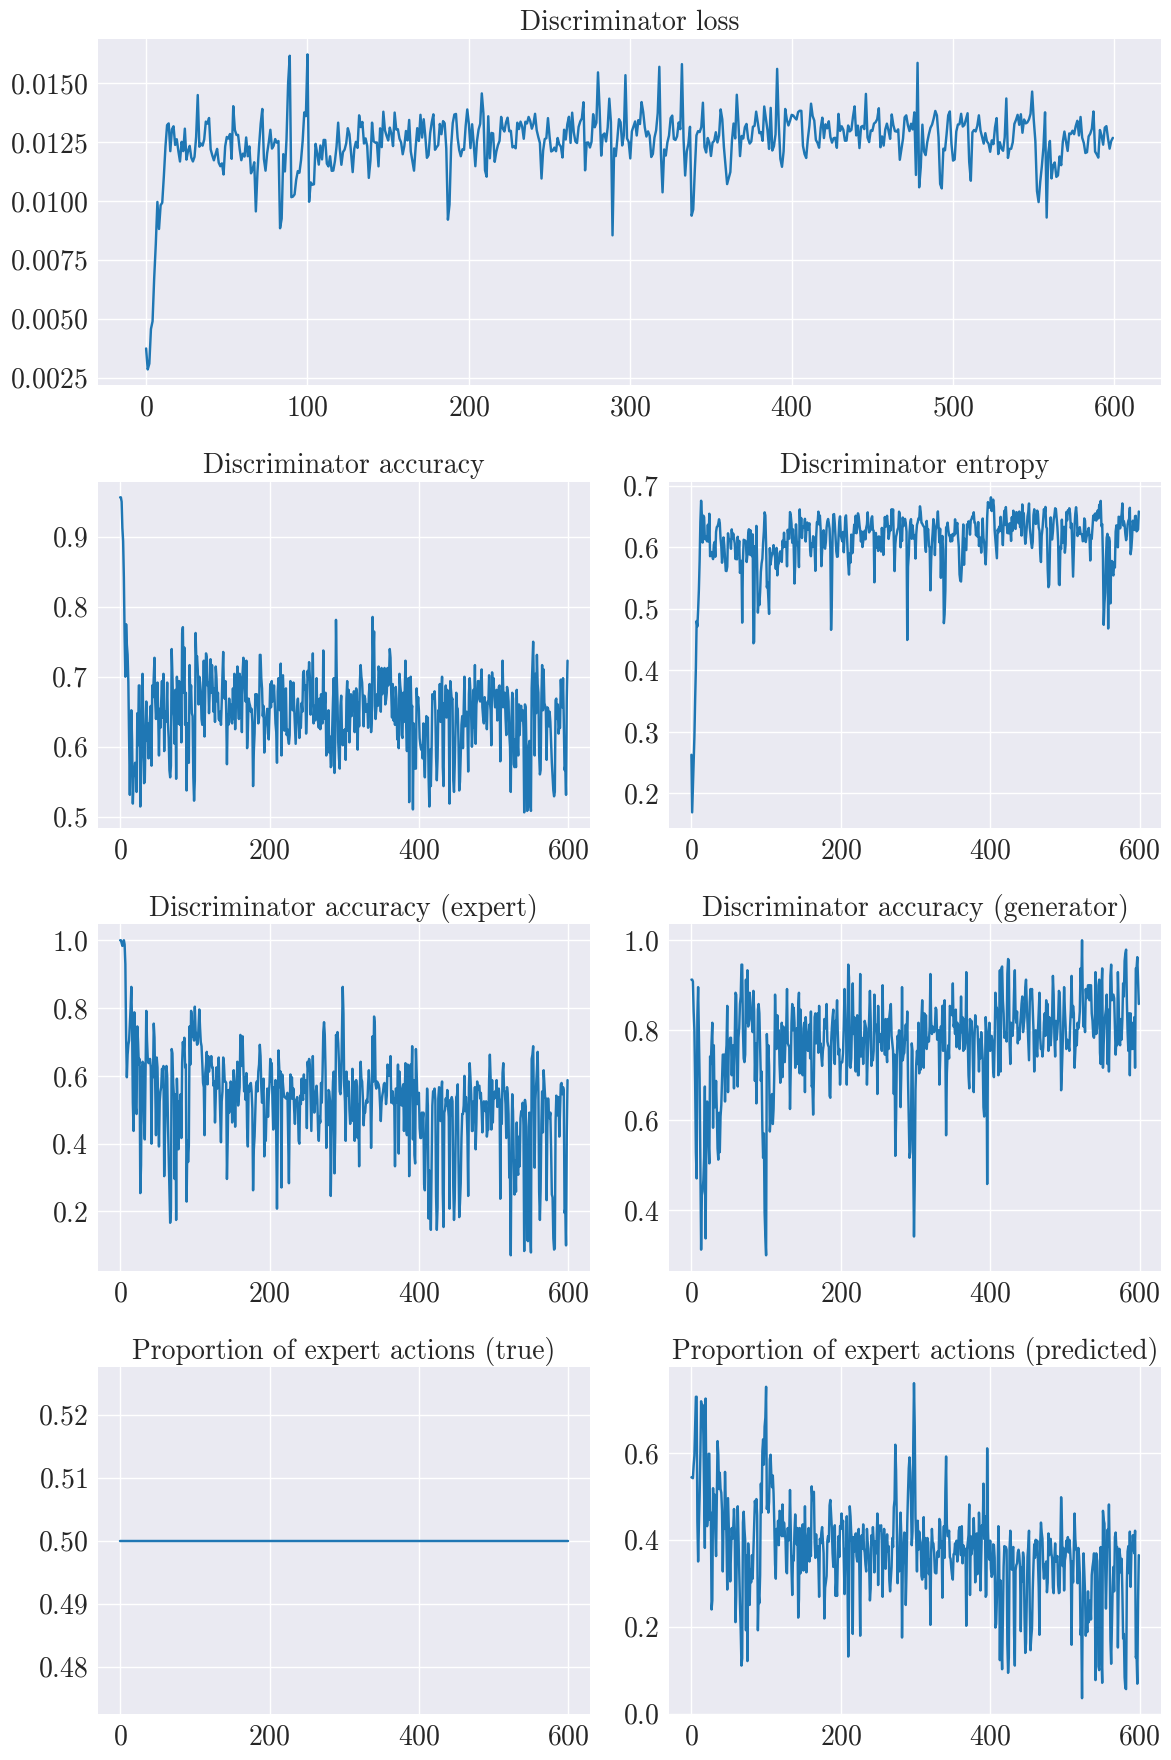

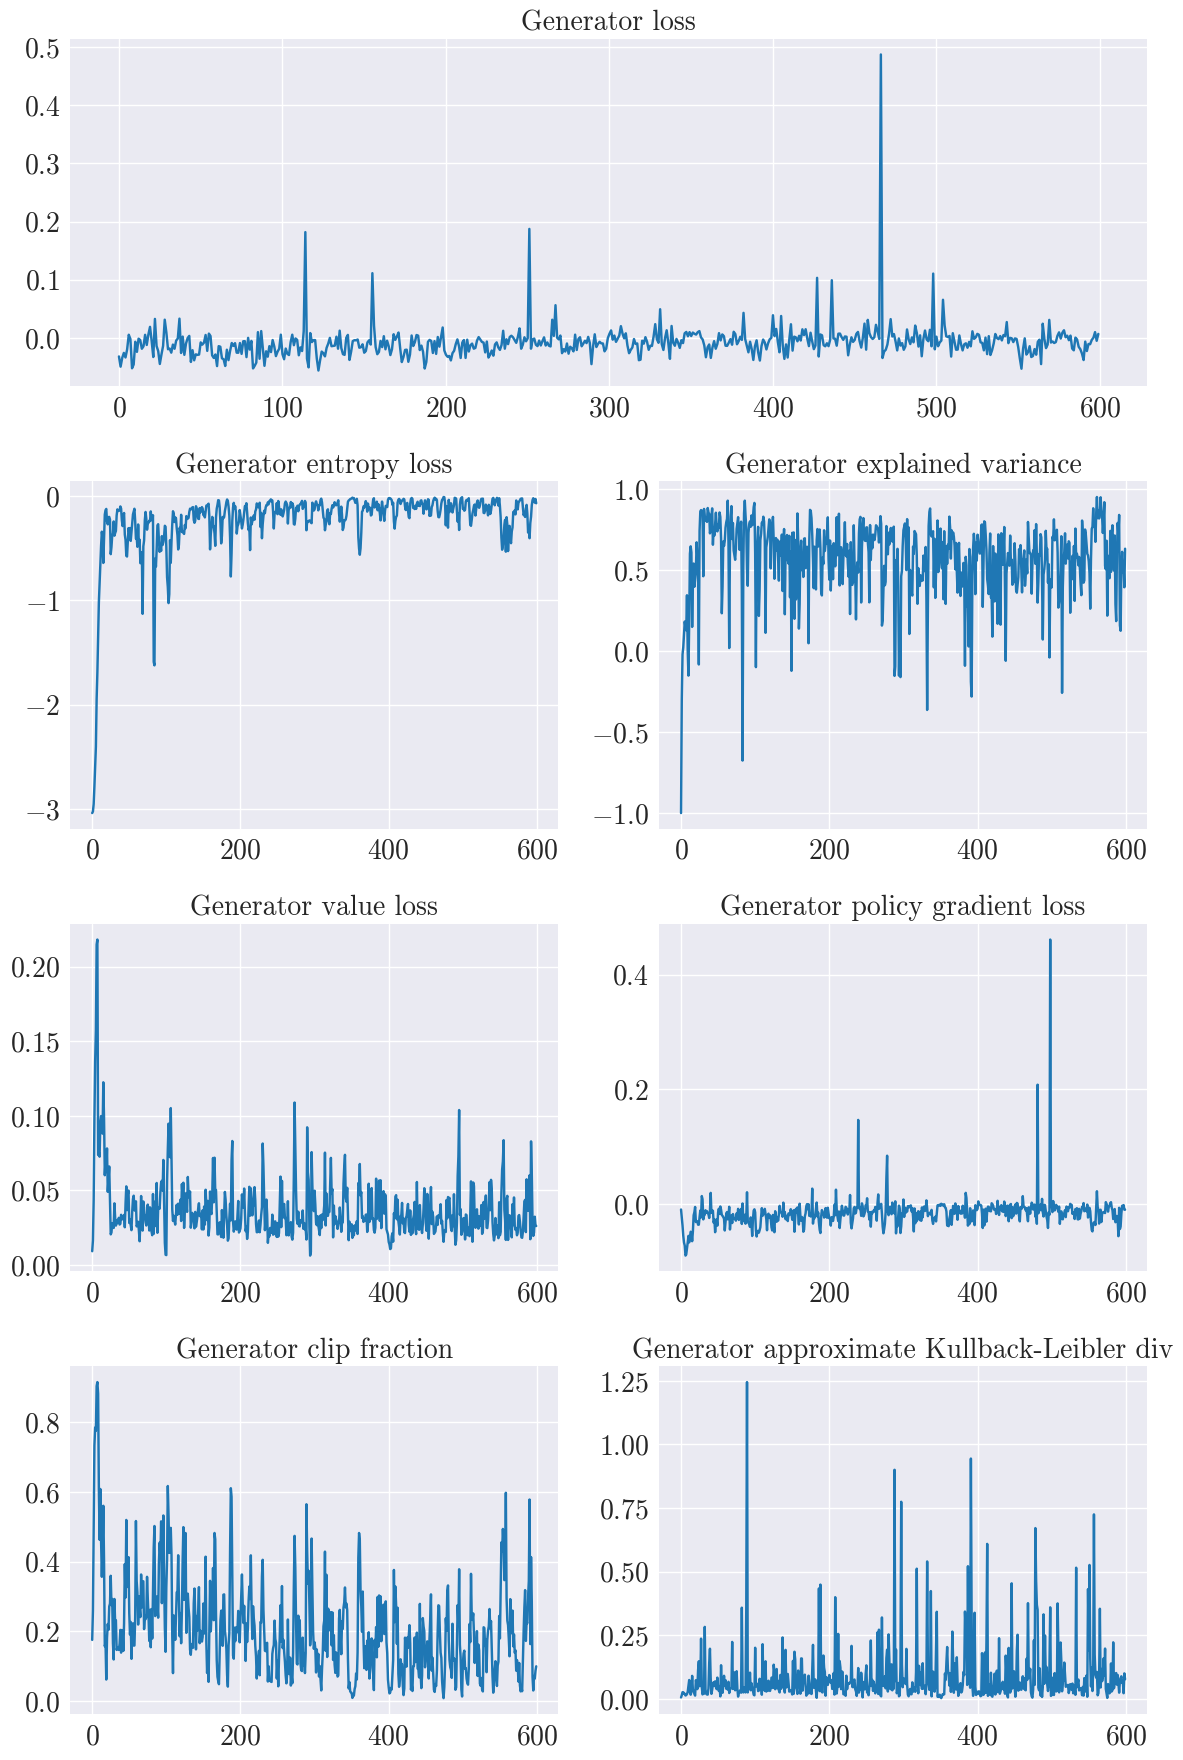

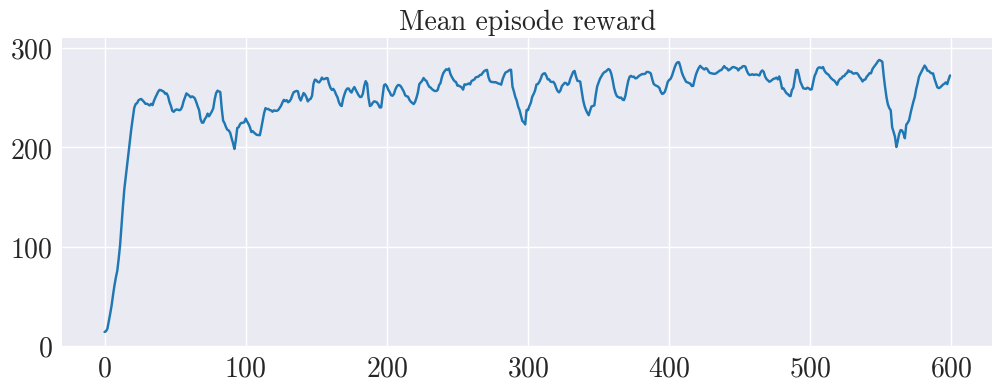

In [39]:
# Visualize the stats
visualize_airl_train_stats(stats, save_fig=SAVE_FIG)

Next, to evaluate the trained AIRL policy you can use the following snippets of code. Note that to evaluate the policy with the out-of-sample data, you will have to reinitialize the `venv` environment with the correct out-of-sample dates (the period between 2023-09-11 and 2023-09-13). Furthermore, these loaded models are models saved at the end of the training process, not necessarily the best performing models found during the training process. One of such models is loaded below in [Section 5: Backtesting pipeline](#section-5-backtesting-pipeline).

In [40]:
# Evaluate the policy after training
venv.seed(SEED)
learner_rewards_after_training, _ = evaluate_policy(
    learner, venv, 5, return_episode_rewards=True
)
print("Reward of the learner policy after training")
print("-------------------------------------------")
print("Mean: ", np.mean(learner_rewards_after_training))
print("Std: ", np.std(learner_rewards_after_training))

Reward of the learner policy after training
-------------------------------------------
Mean:  288.4
Std:  11.77454882362802


In [41]:
# Visualize actions of the policy after training
if PRINT:
    for _ in range(1):
        obs = venv.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs, deterministic=True)
            print(f"Obs: {obs[0][0]: .5f} --> Action: {action}")
            obs, _, done, _ = venv.step(action)

### 4.3. Visualize backtest results

Lastly, we visualize the performance of this loaded model in the out-of-sample backtest period.

In [42]:
# Set parameters
logging = False  # Indicates whether to log events

In [43]:
# Initialize the limit order book and traders
start = time.time()
traders = {}

# Behavior cloning agent
rl_trader_id = "RLMarketMaker"
com_model = BitCommissions(tier=5)
volume = 100
trader = RLMarketMaker(
    id=rl_trader_id,
    com_model=com_model,
    volume=volume,
    policy=learner.policy,
)
traders[rl_trader_id] = trader

description = "AIRL agent."

# Initialize the exchange
exchange = Exchange(
    exchange_name=EXCHANGE,
    symbol_name=SYMBOL,
    tick_size=TICK_SIZE,
    lot_size=LOT_SIZE,
    depth=DEPTH,
    traders=traders,
    max_steps=MAX_STEPS,
    ts_start=TS_START_TEST,
    ts_end=TS_END,
    win=WIN,
    path=PATH,
    path_vol_distr=PATH_VOL_DISTR,
    rl_trader_id=rl_trader_id,
    latency_comp_params=LATENCY_COMP_PARAMS,
    logging=logging,
    ts_save=ts_save,
    description=description,
    rng=RNG,
)
end = round(time.time() - start, 2)
print(f"Time taken for initialization of the exchange: {end} sec.")

# Run the exchange simulation
start = time.time()
exchange.run()
end = round(time.time() - start, 2)
print(f"Time taken for running the exchange: {end} sec.")

Time taken for initialization of the exchange: 0.07 sec.


Running the exchange simulation: 100%|██████████| 32976/32976 [03:16<00:00, 168.17it/s]

Time taken for running the exchange: 196.09 sec.


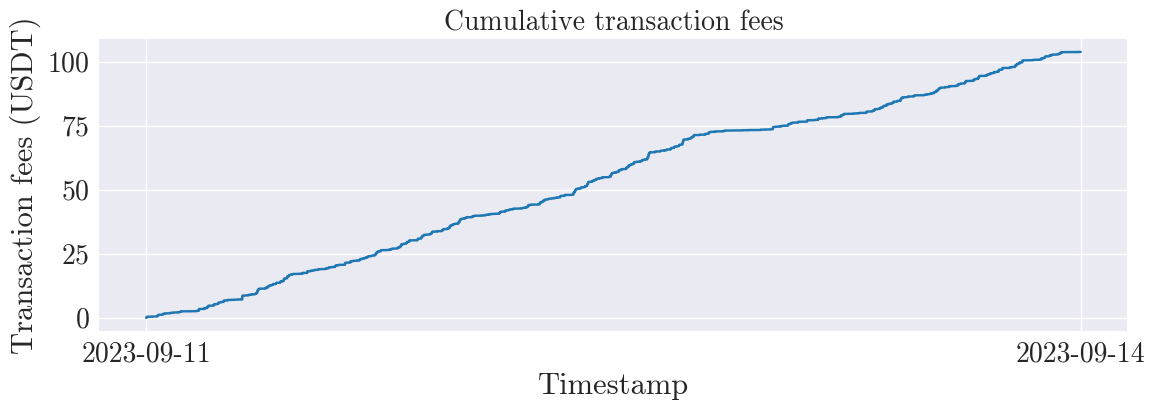

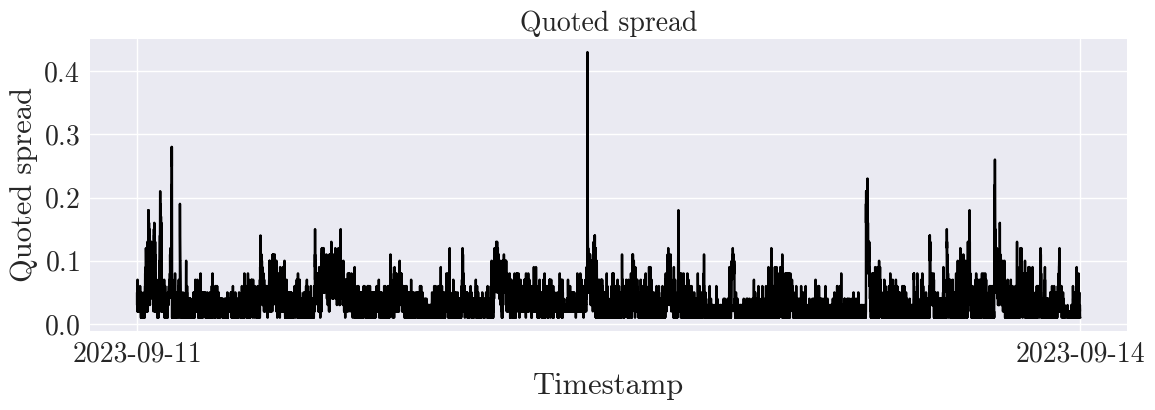

In [44]:
# Visualize backtest results
timestamps = exchange.stats["ts"]
trader_stats = traders[rl_trader_id].stats
initial_cost = 20.5 * volume * 2
visualize_backtest(timestamps, trader_stats, initial_cost)

# Section 5: Backtesting pipeline

In this section, we demonstrate a pipeline for backtesting of the trained AIRL agent. Firstly, we compute backtests for pure market making strategies (with different priorities in aggressiveness of quoted limit orders). In the second subsection, we compute backtests for the pure market making strategy chosen in the paper with $(p=1)$ and fixed quoted volume of $V_q = 100$ SOL.

In [ ]:
def get_commission_tier(priority: int) -> int:
    """
    Determine the commission tier based on priority level.

    Args:
        priority: Priority level (expected values: 0, 1, 2, or 3).

    Returns:
        Commission tier for the given priority.

    Raises:
        ValueError: If the priority level is outside the allowed range.
    """
    # Define a mapping from priority levels to commission tiers
    priority_tiers = {0: 5, 1: 5, 2: 2, 3: 1}

    try:
        return priority_tiers[priority]
    except KeyError as e:
        raise ValueError("Priority must be an integer 0, 1, 2, or 3.") from e
    except Exception as e:
        raise e

### 5.1. Backtesting of pure market makers (with different priorities)

In this section I generate the statistics of the pure market making strategy with multiple priorities $p \in \{0, 1, 2, 3\}$ and a fixed quoted volume of $V_q = 100$ SOL.

In [ ]:
# Set parameters
priorities = [0, 1, 2, 3]  # Priority levels
volume = 100  # Volume of the limit orders
logging = True  # Indicates whether to log events
ts_save = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Ts for model saving

In [ ]:
# Initialize the results dictionary
results = {}

# Run the backtests
for priority in priorities:
    # Pure market making strategy
    trader_id = f"PMM_prior_{priority}_vol_{volume}"
    inventory_manage = True
    description = (
        f"Pure market maker with priority {priority} and volume {volume}."
    )
    tier = get_commission_tier(priority)
    com_model = BitCommissions(tier=tier)
    trader = PureMarketMaker(
        trader_id,
        com_model=com_model,
        volume=volume,
        priority=priority,
        inventory_manage=inventory_manage,
    )
    traders = {}
    traders[trader.id] = trader

    # Initialize the exchange
    exchange = Exchange(
        exchange_name=EXCHANGE,
        symbol_name=SYMBOL,
        tick_size=TICK_SIZE,
        lot_size=LOT_SIZE,
        depth=DEPTH,
        traders=traders,
        max_steps=MAX_STEPS,
        ts_start=TS_START,
        ts_end=TS_END,
        win=WIN,
        path=PATH,
        path_vol_distr=PATH_VOL_DISTR,
        rl_trader_id="",
        latency_comp_params=LATENCY_COMP_PARAMS,
        logging=logging,
        ts_save=ts_save,
        description=description,
        rng=RNG,
    )

    # Run the exchange simulation
    exchange.run()

    # Save the results
    timestamps = exchange.stats["ts"]
    trader_stats = traders[trader_id].stats
    initial_cost = 20.5 * volume * 2
    results[trader_id] = {
        "timestamps": timestamps,
        "trader_stats": trader_stats,
        "initial_cost": initial_cost,
    }

# Send a notification when the backtests are finished
send_notification(message="Backtest finished!", time=20000)

# Save the results to a pickle file
file_path = os.path.join(PATH_AUTOMATED_BACKTESTS, f"results_{ts_save}.pickle")
with open(file_path, "wb") as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Results saved to {file_path}.")

### 5.2. Backtesting of the pure market maker $p=1$ (50 seeds)

In this section, we generate the backtests over 50 random realizations (recall that we use the stochastic backtest simulator) of the pure market maker with priority $p=1$.

In [ ]:
# Set parameters
priorities = [1]  # Priority levels
volume = 100  # Volume of the limit orders
logging = False  # Indicates whether to log events
ts_save = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Ts for model saving

In [ ]:
# Initialize the results dictionary
results = {}

# Run the backtests
for seed in range(1, 51):
    for priority in priorities:
        # Pure market making strategy
        trader_id = f"PMM_prior_{priority}_vol_{volume}_{seed}"
        inventory_manage = True
        description = (
            f"Pure market maker with priority {priority} and volume ",
            f"{volume}.",
        )
        tier = get_commission_tier(priority)
        com_model = BitCommissions(tier=tier)
        trader = PureMarketMaker(
            trader_id,
            com_model=com_model,
            volume=volume,
            priority=priority,
            inventory_manage=inventory_manage,
        )
        traders = {}
        traders[trader.id] = trader

        # Initialize the exchange
        exchange = Exchange(
            exchange_name=EXCHANGE,
            symbol_name=SYMBOL,
            tick_size=TICK_SIZE,
            lot_size=LOT_SIZE,
            depth=DEPTH,
            traders=traders,
            max_steps=MAX_STEPS,
            ts_start=TS_START_TEST,
            ts_end=TS_END,
            win=WIN,
            path=PATH,
            path_vol_distr=PATH_VOL_DISTR,
            rl_trader_id="",
            latency_comp_params=LATENCY_COMP_PARAMS,
            logging=logging,
            ts_save=ts_save,
            description=description,
            rng=RNG,
        )

        # Run the exchange simulation
        exchange.run()

        # Save the results
        timestamps = exchange.stats["ts"]
        trader_stats = traders[trader_id].stats
        initial_cost = 20.5 * volume * 2
        results[trader_id] = {
            "timestamps": timestamps,
            "trader_stats": trader_stats,
            "initial_cost": initial_cost,
        }

# Send a notification when the backtest is finished
send_notification(message="Backtest finished!", time=20000)

# Save the results to a pickle file
file_path = os.path.join(PATH_AUTOMATED_BACKTESTS, f"results_{ts_save}.pickle")
with open(file_path, "wb") as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Results saved to {file_path}.")

### 5.3. Backtesting of the AIRL market maker (50 seeds)

In this section, we generate the backtests over 50 random realizations of the AIRL market maker.

In [ ]:
# Pick the timestamp of the model to load
# ts = "2024-01-21_17-12-35" # seed 1
# ts = "2024-01-22_18-03-01" # seed 2
# ts = "2024-01-23_19-14-27" # seed 3
# ts = "2024-01-24_09-40-47" # seed 4
# ts = "2024-01-24_22-39-37" # seed 5
ts = "2024-01-24_22-39-37_best_9_297.5"  # seed 5 (best model)

In [ ]:
# Load the model
learner, reward_net, stats = load_model(PATH_MODELS, ts)
print(f"Loaded model for timestamp: {ts}")

In [ ]:
# Set parameters
priorities = [1]  # Priority levels
volume = 100  # Volume of the limit orders
logging = False  # Indicates whether to log events
ts_save = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Ts for model saving

In [ ]:
# Initialize the results dictionary
results = {}

for seed in range(1, 51):
    for priority in priorities:
        # AIRL agent
        trader_id = f"RL_prior_{priority}_vol_{volume}_{seed}"
        description = (
            f"RL market maker with priority {priority} and volume {volume}."
        )
        tier = get_commission_tier(priority)
        com_model = BitCommissions(tier=tier)
        trader = RLMarketMaker(
            id=trader_id,
            com_model=com_model,
            volume=volume,
            policy=learner.policy,
        )
        traders = {}
        traders[trader.id] = trader

        # Initialize the exchange
        exchange = Exchange(
            exchange_name=EXCHANGE,
            symbol_name=SYMBOL,
            tick_size=TICK_SIZE,
            lot_size=LOT_SIZE,
            depth=DEPTH,
            traders=traders,
            max_steps=MAX_STEPS,
            ts_start=TS_START_TEST,
            ts_end=TS_END,
            win=WIN,
            path=PATH,
            path_vol_distr=PATH_VOL_DISTR,
            rl_trader_id=trader_id,
            latency_comp_params=LATENCY_COMP_PARAMS,
            logging=logging,
            ts_save=ts_save,
            description=description,
            rng=RNG,
        )

        # Run the exchange simulation
        exchange.run()

        # Save the results
        timestamps = exchange.stats["ts"]
        trader_stats = traders[trader_id].stats
        initial_cost = 20.5 * volume * 2
        results[trader_id] = {
            "timestamps": timestamps,
            "trader_stats": trader_stats,
            "initial_cost": initial_cost,
        }

# Send a notification when the backtest is finished
send_notification(message="Backtest finished!", time=20000)

# Save the results to a pickle file
file_path = os.path.join(PATH_AUTOMATED_BACKTESTS, f"results_{ts_save}.pickle")
with open(file_path, "wb") as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Results saved to {file_path}.")

This concludes the backtesting pipeline that was used in our paper. The backtests are saved to the `data/automated_backtests` directory and can be loaded and visualized in the following section.

# Section 6: Visualization of backtests

In this section, we visualize the backtest results from the previous section.

Firstly, let us define some helper functions for the visualization of the backtests.

In [45]:
# Define helper functions for plotting


def compute_trade_hit_probabilities(results: dict) -> None:
    """
    Compute and print hitting probabilities for each strategy.

    Args:
        results: Dictionary containing strategy results with trade counts.
    """
    print("Hitting probabilities:")
    for key, value in results.items():
        trades = np.array(value["trader_stats"]["trade_count"])
        hits = np.where(trades > 0, 1, 0)
        print(f"  {key} - Hitting probability: {np.mean(hits)*100:.2f} %")


def get_mean_and_std(results: dict, metric: str) -> tuple[float, float]:
    """
    Get the mean and standard deviation of the given metric.

    Args:
        results: Dictionary containing strategy results with timestamps and
            trader stats.
        metric: Metric to calculate the mean and standard deviation.

    Returns:
        Tuple containing the mean and standard deviation of the given metric.
    """
    values = []
    for value in results.values():
        y = np.array(value["trader_stats"][metric])
        values.append(y[-1])
    return np.mean(values), np.std(values)


def compute_returns(
    trader_stats: dict, initial_cost: float
) -> tuple[pd.Series, pd.Series]:
    """
    Compute equity and returns from the trader statistics.

    Args:
        trader_stats: Dictionary containing trader statistics.
        initial_cost: Initial capital used for trading.

    Returns:
        Tuple containing the equity and returns series.
    """
    equity = pd.Series(np.array(trader_stats["adj_pnl"]) + initial_cost)
    returns = equity.pct_change() * 100
    return equity, returns


def fig_path(file_name: str, save_fig: bool) -> str:
    """
    Get the path to save the figure.

    Args:
        file_name: Name of the file.
        save_fig: Flag indicating whether to save the figure. If False, the
            function returns None.

    Returns:
        Path to save the figure.
    """
    if save_fig:
        return os.path.join(PATH_FIGURES, file_name)
    return None

### 6.1. Visualize the backtest of the pure market maker $p=1$

In the following, we visualize the backtest statistics of the pure market maker with priority $p=1$ (the expert policy that was used as a target market making strategy in the AIRL training process).

In [46]:
# Set the to the results file
file_path = "data/automated_backtests/results_2024-02-25_10-58-39.pickle"

# Load results from the selected file
with open(file_path, "rb") as handle:
    results = pickle.load(handle)

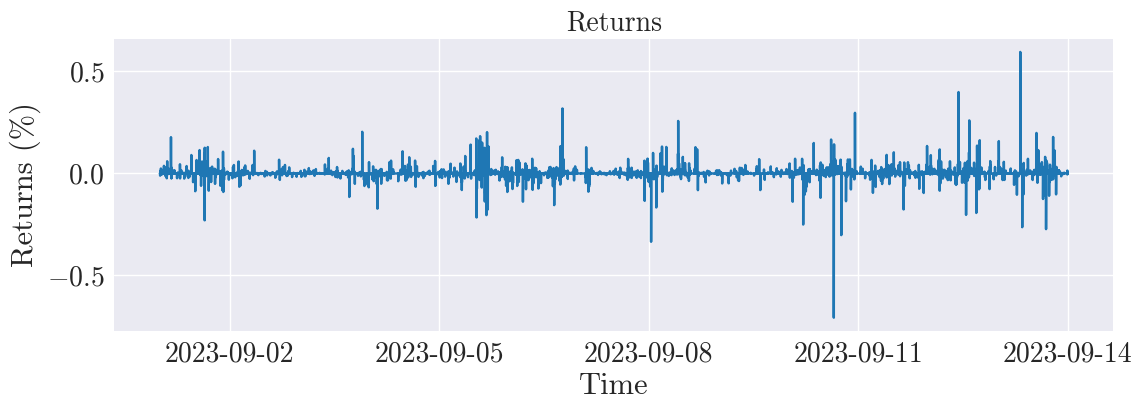

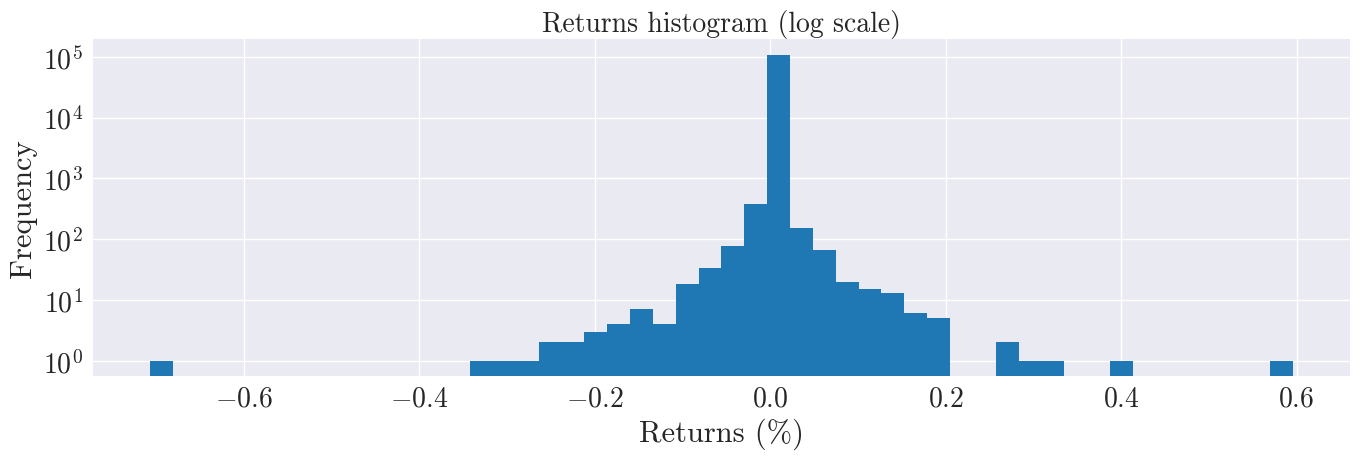

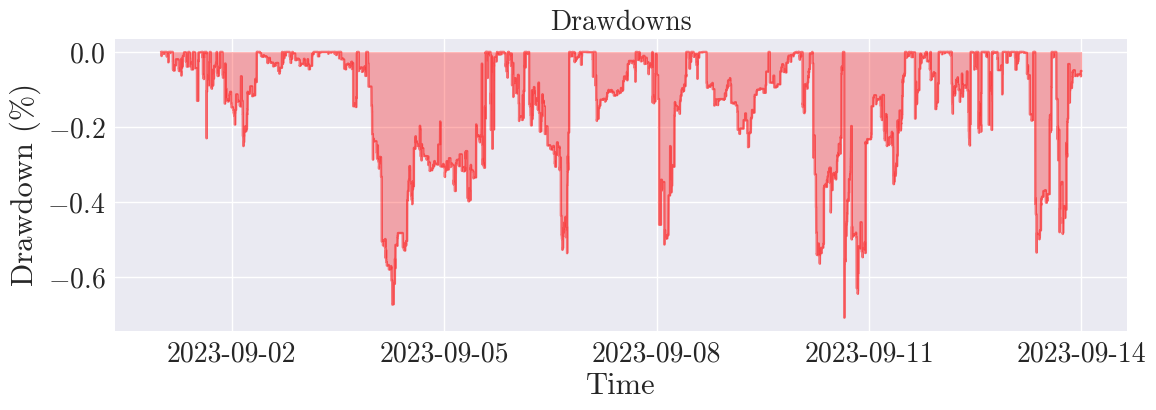

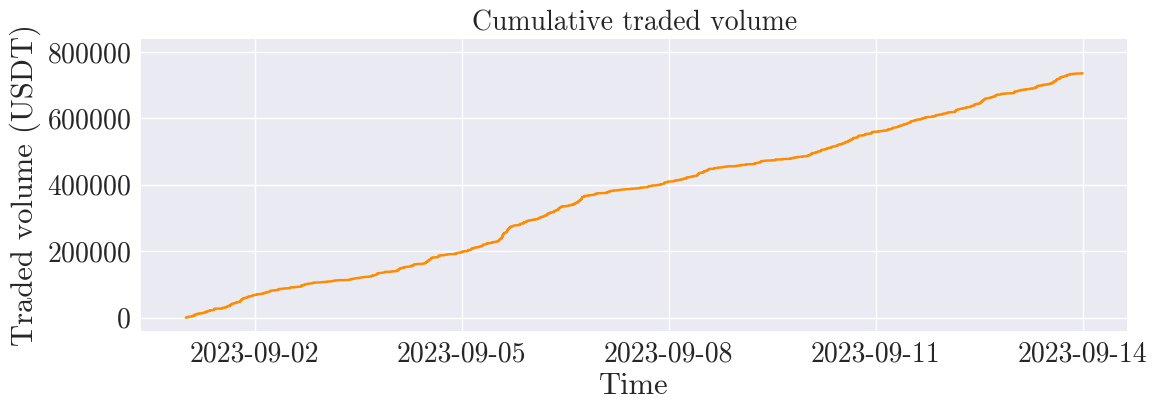

In [47]:
# Load results
ts = results["PMM_prior_1_vol_100"]["timestamps"]
trader_stats = results["PMM_prior_1_vol_100"]["trader_stats"]
initial_cost = results["PMM_prior_1_vol_100"]["initial_cost"]

# ------------------------------------------------------------------------------
# Plot results
# ------------------------------------------------------------------------------
# PLOT - Adjusted PnL
path = fig_path("PMM_pnl.pdf", SAVE_FIG)
title = r"P&L evolution" if PLOT_TITLE else None
make_plot(
    x=ts,
    y=trader_stats["adj_pnl"],
    title=title,
    xlabel="Time",
    ylabel="P&L (USDT)",
    save_path=path,
)

# PLOT - Returns
equity = pd.Series(np.array(trader_stats["adj_pnl"]) + initial_cost)
returns = equity.pct_change() * 100
path = fig_path("PMM_returns.pdf", SAVE_FIG)
title = "Returns" if PLOT_TITLE else None
make_plot(
    x=ts,
    y=returns,
    title=title,
    xlabel="Time",
    ylabel="Returns (%)",
    save_path=path,
)

# PLOT - Histogram of returns
fig = plt.figure(figsize=FIG_SIZE)
plt.hist(returns, bins=50, alpha=1, log=True)
if PLOT_TITLE:
    plt.title("Returns histogram (log scale)")
plt.xlabel("Returns (%)")
plt.ylabel("Frequency")
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_returns_hist.pdf"))

# PLOT - Drawdowns
dd = drawdowns(equity)
path = fig_path("PMM_drawdowns.pdf", SAVE_FIG)
title = "Drawdowns" if PLOT_TITLE else None
make_drawdown_plot(
    x=ts,
    y=dd,
    title=title,
    xlabel="Time",
    ylabel="Drawdown (%)",
    save_path=path,
)

# PLOT - Inventory
path = fig_path("PMM_inventory.pdf", SAVE_FIG)
title = "Inventory evolution" if PLOT_TITLE else None
make_plot(
    x=ts,
    y=trader_stats["inventory"],
    title=title,
    xlabel="Time",
    ylabel="Inventory (SOL)",
    color="darkorange",
    save_path=path,
)

# PLOT - Total traded volume
path = fig_path("PMM_volume.pdf", SAVE_FIG)
title = "Cumulative traded volume" if PLOT_TITLE else None
make_plot(
    x=ts,
    y=trader_stats["total_volume"],
    title=title,
    xlabel="Time",
    ylabel="Traded volume (USDT)",
    ylim=(-40000, 840000),
    color="darkorange",
    save_path=path,
)

# PLOT - Transaction costs
path = fig_path("PMM_fees.pdf", SAVE_FIG)
title = "Cumulative transaction fees" if PLOT_TITLE else None
make_plot(
    x=ts,
    y=trader_stats["cum_costs"],
    title=title,
    xlabel="Time",
    ylabel="Transaction fees (USDT)",
    ylim=(-20, 420),
    color="red",
    save_path=path,
)

# ------------------------------------------------------------------------------
# Print detailed statistics
# ------------------------------------------------------------------------------
if PRINT:
    print(f"Final P&L: {trader_stats['adj_pnl'][-1]}")
    print()
    print("Returns stats")
    print(returns.describe())
    print()
    print("Drawdown stats")
    print(dd.describe())
    print()
    print("Inventory stats")
    print(pd.Series(trader_stats["inventory"]).describe())
    print()
    print("Total volume: ", trader_stats["total_volume"][-1])
    print("Total fees: ", trader_stats["cum_costs"][-1])

### 6.2. Visualize backtests of pure market making strategies with different $p$

In this section, we visualize the backtest statistics of the pure market making strategies with different priorities $p \in \{0, 1, 2, 3\}$.

In [48]:
# Set the path to the results file
file_path = "data/automated_backtests/results_2024-02-25_10-58-39.pickle"

# Load the results from a pickle file
with open(file_path, "rb") as handle:
    results = pickle.load(handle)

In [49]:
def plot_spread_histogram(
    results: dict, save_fig: bool = False, title: str = None
) -> None:
    """
    Plot spread histogram for each strategy's quoted ask and bid prices.

    Args:
        results: Dictionary containing strategy results with trader stats.
        save_fig: Whether to save the figure. Default is False.
        title: Title of the plot. Default is None.
    """
    index = 0
    plt.figure(figsize=FIG_SIZE)

    for value in results.values():
        spread = np.array(value["trader_stats"]["quoted_ask_price"]) - np.array(
            value["trader_stats"]["quoted_bid_price"]
        )
        label = f"PMM (priority {index})"
        plt.hist(spread, bins=50, alpha=0.75, log=False, label=label)
        mean = np.mean(spread)
        plt.vlines(mean, 0, 50000, color=f"C{index}", linestyle="--")
        index += 1

    plt.xlabel("Spread (USDT)")
    plt.ylabel("Count")
    plt.xlim(0, 0.24)  # Cut off outliers
    plt.xticks(np.arange(0, 0.24, 0.01), rotation=45)
    plt.legend()
    plt.tight_layout()
    if title:
        plt.title(title)

    # Save the figure if required
    if save_fig:
        plt.savefig(os.path.join(PATH_FIGURES, "PMM_comparison_spread.pdf"))

    plt.show()

    # Print the statistics for the spread
    print("Spread statistics:")
    for key, value in results.items():
        spread = np.array(value["trader_stats"]["quoted_ask_price"]) - np.array(
            value["trader_stats"]["quoted_bid_price"]
        )
        print(f"  {key} - Mean spread: {np.mean(spread):.4f}")
    print()

Statistics for adj_pnl:
  PMM_prior_0_vol_100 - Final adj pnl: 35.96
  PMM_prior_1_vol_100 - Final adj pnl: 303.64
  PMM_prior_2_vol_100 - Final adj pnl: 35.91
  PMM_prior_3_vol_100 - Final adj pnl: -13.09



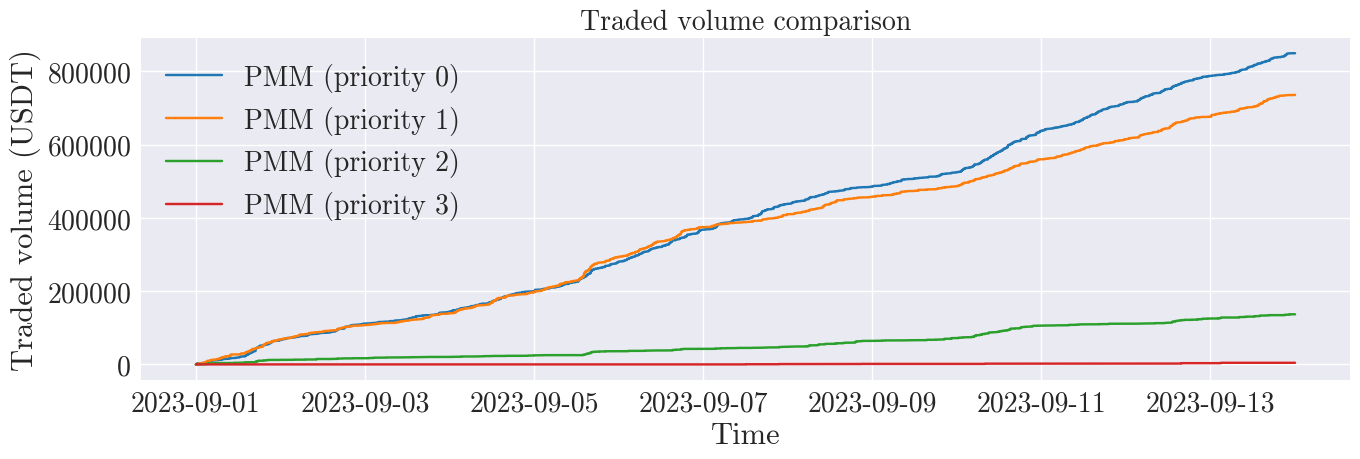

Statistics for total_volume:
  PMM_prior_0_vol_100 - Final total volume: 849281.99
  PMM_prior_1_vol_100 - Final total volume: 735615.47
  PMM_prior_2_vol_100 - Final total volume: 136708.70
  PMM_prior_3_vol_100 - Final total volume: 4422.66



Spread statistics:
  PMM_prior_0_vol_100 - Mean spread: 0.0190
  PMM_prior_1_vol_100 - Mean spread: 0.0312
  PMM_prior_2_vol_100 - Mean spread: 0.0557
  PMM_prior_3_vol_100 - Mean spread: 0.0793

Hitting probabilities:
  PMM_prior_0_vol_100 - Hitting probability: 3.13 %
  PMM_prior_1_vol_100 - Hitting probability: 2.08 %
  PMM_prior_2_vol_100 - Hitting probability: 0.35 %
  PMM_prior_3_vol_100 - Hitting probability: 0.01 %


In [50]:
# P&L visualization
path = fig_path("PMM_comparison_pnl.pdf", SAVE_FIG)
title = "P&L comparison" if PLOT_TITLE else None
plot_multi_results(
    results=results,
    metric="adj_pnl",
    ylabel="P&L (USDT)",
    title=title,
    figsize=FIG_SIZE,
    save_path=path,
)

# Traded volume visualization
path = fig_path("PMM_comparison_volume.pdf", SAVE_FIG)
title = "Traded volume comparison" if PLOT_TITLE else None
plot_multi_results(
    results=results,
    metric="total_volume",
    ylabel="Traded volume (USDT)",
    title=title,
    figsize=FIG_SIZE,
    save_path=path,
)

# Spread histogram visualization
title = "Spread histogram comparison" if PLOT_TITLE else None
plot_spread_histogram(results, save_fig=SAVE_FIG, title=title)

# Compute trade hitting probabilities
compute_trade_hit_probabilities(results)

### 6.3. Compare results of the pure market making strategy with $p=1$ over 50 different realizations

In this subsection, we compare backtest results over 50 different realizations (seeds 1-50) in the out-of-sample period for the pure market making strategy with priority $p=1$. We do so to demonstrate the robustness of the strategy in our stochastic backtest simulator.

In [51]:
# Set the path to the results file
file_path = "data/automated_backtests/results_2024-02-25_15-16-39.pickle"

# Load the results from a pickle file
with open(file_path, "rb") as handle:
    results_pmm = pickle.load(handle)

In [52]:
# Visualize the P&L plot
path = fig_path("PMM_comparison_pnl.pdf", SAVE_FIG)
title = "P&L evolution" if PLOT_TITLE else None
plot_multi_results(
    results=results_pmm,
    metric="adj_pnl",
    ylabel="P&L (USDT)",
    ylim=(-60, 210),
    legend=False,
    title=title,
    print_stats=False,
    locator_interval=1,
    figsize=FIG_SIZE,
    save_path=path,
)

In [53]:
# Print the mean and standard deviation of the P&L for PMM strategies
mean, std = get_mean_and_std(results_pmm, "adj_pnl")
print("Mean and std of P&L for PMM strategies:")
print("---------------------------------------")
print(f"Mean P&L: {mean:.2f}")
print(f"Std P&L: {std:.2f}")

Mean and std of P&L for PMM strategies:
---------------------------------------
Mean P&L: 94.34
Std P&L: 39.59


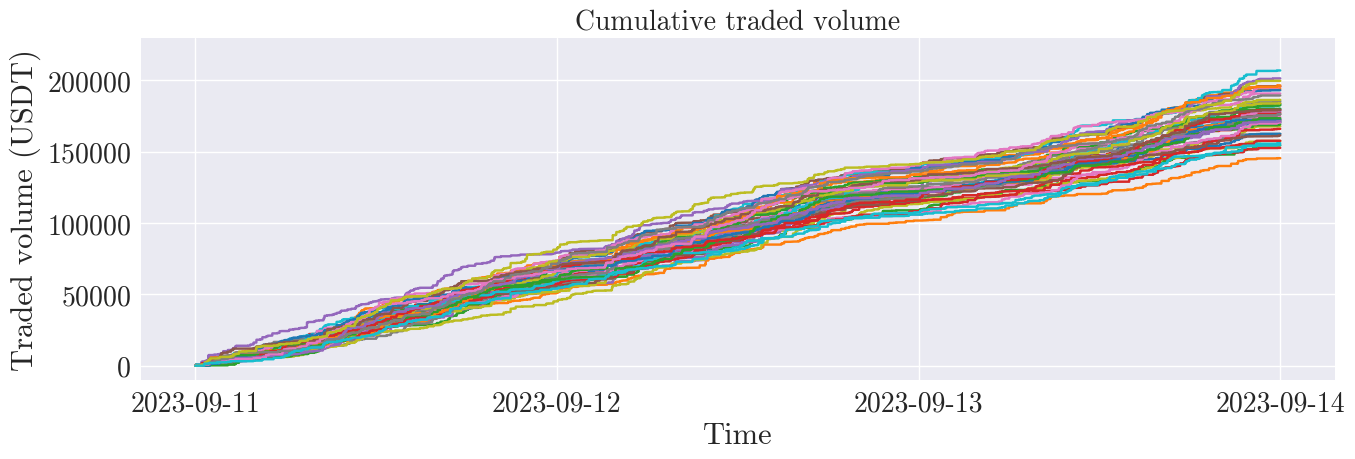

In [54]:
# Visualize the volume plot
path = fig_path("PMM_comparison_volume.pdf", SAVE_FIG)
title = "Cumulative traded volume"
plot_multi_results(
    results=results_pmm,
    metric="total_volume",
    ylabel="Traded volume (USDT)",
    ylim=(-10000, 230000),
    legend=False,
    title=title,
    print_stats=False,
    locator_interval=1,
    figsize=FIG_SIZE,
    save_path=path,
)

In [55]:
# Print the mean and standard deviation of the traded volume
mean, std = get_mean_and_std(results_pmm, "total_volume")
print("Mean and std of traded volume for PMM strategies:")
print("-------------------------------------------------")
print(f"Mean volume: {mean:.2f}")
print(f"Std volume: {std:.2f}")

Mean and std of traded volume for PMM strategies:
-------------------------------------------------
Mean volume: 176624.78
Std volume: 13934.94


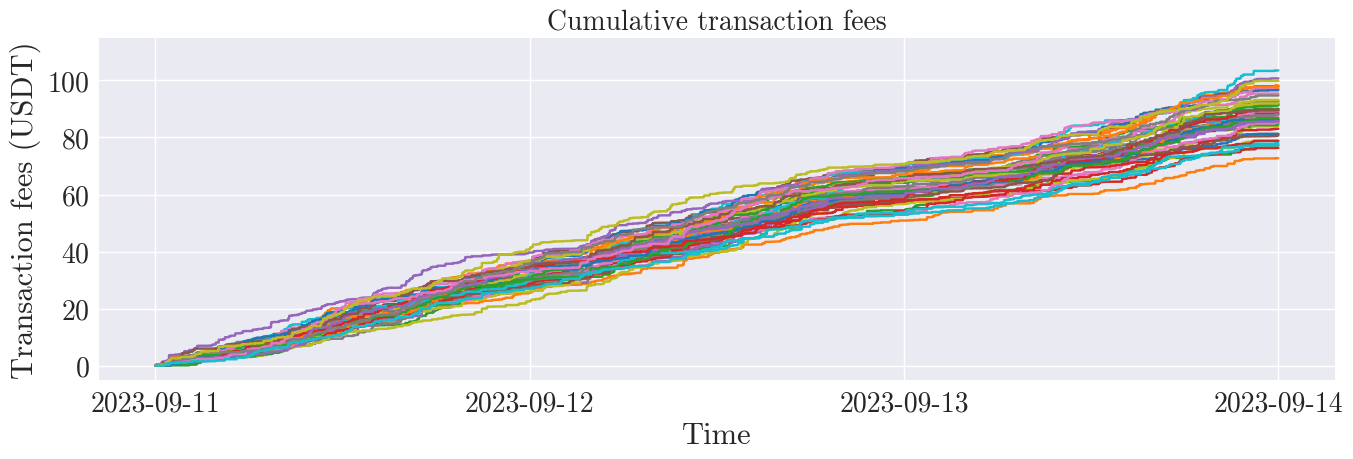

In [56]:
# Visualize the cumulative transaction fees
path = fig_path("PMM_comparison_fees.pdf", SAVE_FIG)
title = "Cumulative transaction fees" if PLOT_TITLE else None
plot_multi_results(
    results=results_pmm,
    metric="cum_costs",
    ylabel="Transaction fees (USDT)",
    ylim=(-5, 115),
    legend=False,
    title=title,
    print_stats=False,
    locator_interval=1,
    figsize=FIG_SIZE,
    save_path=path,
)

In [57]:
# Print the mean and standard deviation of the transaction fees
mean, std = get_mean_and_std(results_pmm, "cum_costs")
print("Mean and std of transaction fees for PMM strategies:")
print("----------------------------------------------------")
print(f"Mean fees: {mean:.2f}")
print(f"Std fees: {std:.2f}")

Mean and std of transaction fees for PMM strategies:
----------------------------------------------------
Mean fees: 88.31
Std fees: 6.97


In [58]:
# Print the mean and standard deviation of the hitting probabilities
avg = []
for value in results_pmm.values():
    trades = np.array(value["trader_stats"]["trade_count"])
    hits = np.where(trades > 0, 1, 0)
    avg.append(np.mean(hits) * 100)

print("Mean and std of hitting probabilities for PMM strategies:")
print("---------------------------------------------------------")
print(f"Mean hitting probability: {np.mean(avg):.2f}%")
print(f"Std hitting probability: {np.std(avg):.2f}")

Mean and std of hitting probabilities for PMM strategies:
---------------------------------------------------------
Mean hitting probability: 1.62%
Std hitting probability: 0.07


### 6.4. Compare results of the AIRL market making strategy over 50 different realizations

Next, we compare the backtest results over 50 different realizations of the AIRL market making strategy in the out-of-sample period. Again, this is to demonstrate the robustness of the strategy in our stochastic backtest simulator.

In [59]:
# Set the path to the results file
file_path = "data/automated_backtests/results_2024-02-25_21-22-46.pickle"

# Load the results from a pickle file
with open(file_path, "rb") as handle:
    results_airl = pickle.load(handle)

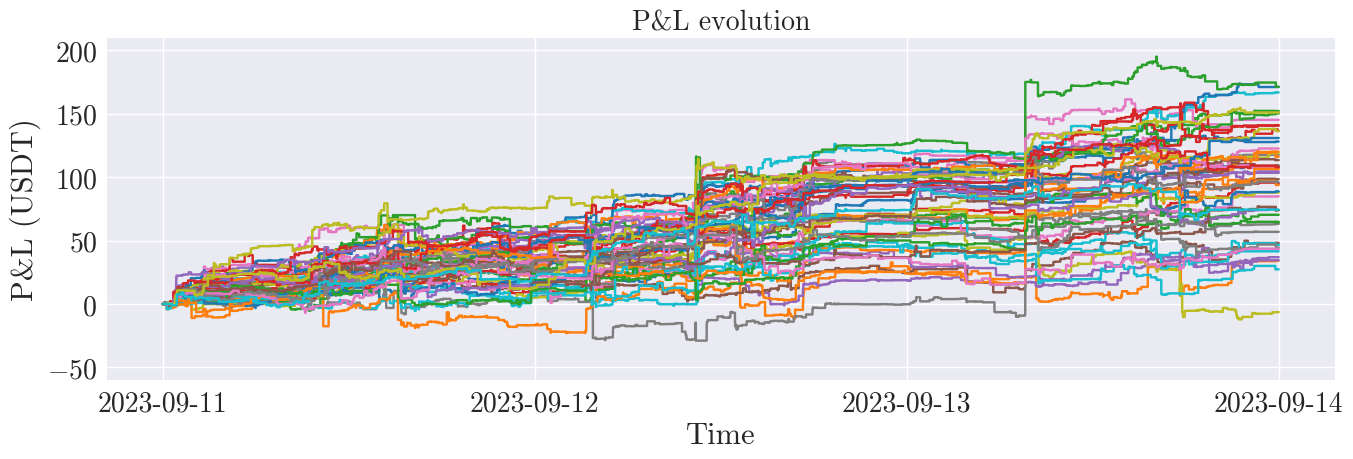

In [60]:
# Visualize the P&L plot
path = fig_path("AIRL_comparison_pnl.pdf", SAVE_FIG)
title = "P&L evolution" if PLOT_TITLE else None
plot_multi_results(
    results=results_airl,
    metric="adj_pnl",
    ylabel="P&L (USDT)",
    ylim=(-60, 210),
    legend=False,
    title=title,
    print_stats=False,
    locator_interval=1,
    figsize=FIG_SIZE,
    save_path=path,
)

In [61]:
# Print the mean and standard deviation of the P&L for AIRL strategies
mean, std = get_mean_and_std(results_airl, "adj_pnl")
print("Mean and std of P&L for AIRL strategies:")
print("----------------------------------------")
print(f"Mean P&L: {mean:.2f}")
print(f"Std P&L: {std:.2f}")

Mean and std of P&L for AIRL strategies:
----------------------------------------
Mean P&L: 96.94
Std P&L: 41.62


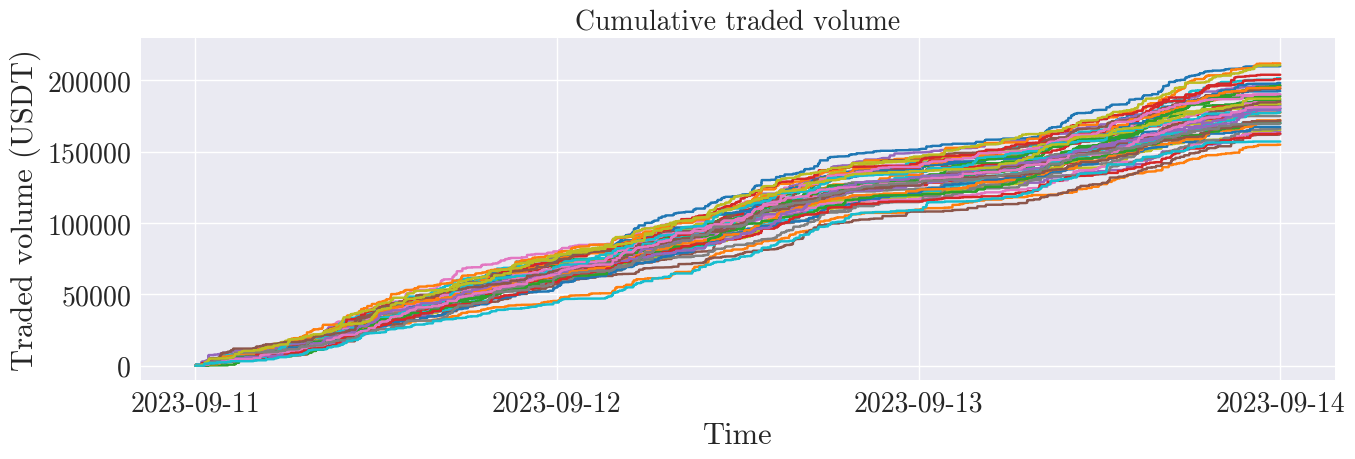

In [62]:
# Visualize the volume plot
path = fig_path("AIRL_comparison_volume.pdf", SAVE_FIG)
title = "Cumulative traded volume"
plot_multi_results(
    results=results_airl,
    metric="total_volume",
    ylabel="Traded volume (USDT)",
    ylim=(-10000, 230000),
    legend=False,
    title=title,
    print_stats=False,
    locator_interval=1,
    figsize=FIG_SIZE,
    save_path=path,
)

In [63]:
# Print the mean and standard deviation of the traded volume
mean, std = get_mean_and_std(results_airl, "total_volume")
print("Mean and std of traded volume for AIRL strategies:")
print("--------------------------------------------------")
print(f"Mean volume: {mean:.2f}")
print(f"Std volume: {std:.2f}")

Mean and std of traded volume for AIRL strategies:
--------------------------------------------------
Mean volume: 182269.08
Std volume: 14139.32


In [64]:
# Visualize the cumulative transaction fees
path = fig_path("AIRL_comparison_fees.pdf", SAVE_FIG)
title = "Cumulative transaction fees" if PLOT_TITLE else None
plot_multi_results(
    results=results_airl,
    metric="cum_costs",
    ylabel="Transaction fees (USDT)",
    ylim=(-5, 115),
    legend=False,
    title=title,
    print_stats=False,
    locator_interval=1,
    figsize=FIG_SIZE,
    save_path=path,
)

In [65]:
# Print the mean and standard deviation of the transaction fees
mean, std = get_mean_and_std(results_airl, "cum_costs")
print("Mean and std of transaction fees for AIRL strategies:")
print("-----------------------------------------------------")
print(f"Mean fees: {mean:.2f}")
print(f"Std fees: {std:.2f}")

Mean and std of transaction fees for AIRL strategies:
-----------------------------------------------------
Mean fees: 91.13
Std fees: 7.07


In [66]:
# Print the mean and standard deviation of the hitting probabilities
avg = []
for value in results_airl.values():
    trades = np.array(value["trader_stats"]["trade_count"])
    hits = np.where(trades > 0, 1, 0)
    avg.append(np.mean(hits) * 100)
print("Mean and std of hitting probabilities for AIRL strategies:")
print("----------------------------------------------------------")
print(f"Mean hitting probability: {np.mean(avg):.2f}%")
print(f"Std hitting probability: {np.std(avg):.2f}")

Mean and std of hitting probabilities for AIRL strategies:
----------------------------------------------------------
Mean hitting probability: 1.61%
Std hitting probability: 0.07


### 6.5. Compare results of the pure market making strategy with $p=1$ and the AIRL market making strategy on a single realization

In this section, we compare the backtest results of the pure market making strategy with priority $p=1$ and the AIRL market making strategy on a single realization.

In [67]:
# Fix the seed for visualization.
# We select this seed as the terminal P&Ls of both strategies are close.
SEED_VISUAL = 4

Firstly, visualize the backtest results of the pure market making strategy with priority $p=1$.

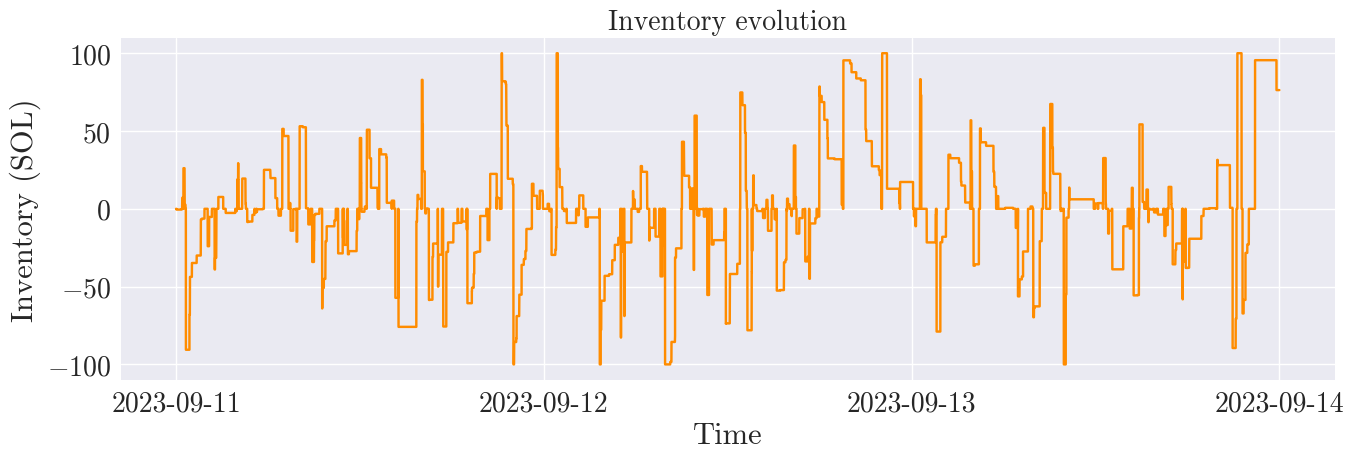

In [68]:
# PMM - Load data
pmm_data = results_pmm[f"PMM_prior_1_vol_100_{SEED_VISUAL}"]
pmm_ts, pmm_trader_stats, pmm_initial_cost = (
    pmm_data["timestamps"],
    pmm_data["trader_stats"],
    pmm_data["initial_cost"],
)

# PMM - Plot P&L
path = fig_path("PMM_seeds_pnl.pdf", SAVE_FIG)
title = "P&L evolution" if PLOT_TITLE else None
make_plot(
    x=pmm_ts,
    y=pmm_trader_stats["adj_pnl"],
    title=title,
    xlabel="Time",
    ylabel="P&L (USDT)",
    save_path=path,
    loc_interval=1,
    figsize=FIG_SIZE,
)

# PMM - Plot returns
pmm_equity, pmm_returns = compute_returns(pmm_trader_stats, pmm_initial_cost)
path = fig_path("PMM_seeds_returns.pdf", SAVE_FIG)
title = "Returns" if PLOT_TITLE else None
make_plot(
    x=pmm_ts,
    y=pmm_returns,
    title=title,
    xlabel="Time",
    ylabel="Returns (%)",
    save_path=path,
    loc_interval=1,
    figsize=FIG_SIZE,
)

# PMM - Plot drawdowns
pmm_dd = drawdowns(pmm_equity)
path = fig_path("PMM_seeds_drawdowns.pdf", SAVE_FIG)
title = "Drawdowns" if PLOT_TITLE else None
make_drawdown_plot(
    x=pmm_ts,
    y=pmm_dd,
    title=title,
    xlabel="Time",
    ylabel="Drawdown (%)",
    save_path=path,
    loc_interval=1,
    figsize=FIG_SIZE,
)

# PMM - Plot inventory
path = fig_path("PMM_seeds_inventory.pdf", SAVE_FIG)
title = "Inventory evolution" if PLOT_TITLE else None
make_plot(
    x=pmm_ts,
    y=pmm_trader_stats["inventory"],
    title=title,
    xlabel="Time",
    ylabel="Inventory (SOL)",
    save_path=path,
    loc_interval=1,
    figsize=FIG_SIZE,
    color="darkorange",
)

# PMM - Plot total traded volume
path = fig_path("PMM_seeds_volume.pdf", SAVE_FIG)
title = "Cumulative traded volume" if PLOT_TITLE else None
make_plot(
    x=pmm_ts,
    y=pmm_trader_stats["total_volume"],
    title=title,
    xlabel="Time",
    ylabel="Traded volume (USDT)",
    save_path=path,
    loc_interval=1,
    figsize=FIG_SIZE,
    color="darkorange",
)

# PMM - Plot transaction fees
path = fig_path("PMM_seeds_fees.pdf", SAVE_FIG)
title = "Transaction fees" if PLOT_TITLE else None
make_plot(
    x=pmm_ts,
    y=pmm_trader_stats["cum_costs"],
    title=title,
    xlabel="Time",
    ylabel="Transaction fees (USDT)",
    save_path=path,
    loc_interval=1,
    figsize=FIG_SIZE,
    color="red",
)

if PRINT:
    print(f"Final P&L: {pmm_trader_stats['adj_pnl'][-1]}")
    print()
    print("Returns stats")
    print(pmm_returns.describe())
    print()
    print("Drawdown stats")
    print(pmm_dd.describe())
    print()
    print("Inventory stats")
    print(pd.Series(pmm_trader_stats["inventory"]).describe())
    print()
    print("Total volume:", pmm_trader_stats["total_volume"][-1])
    print()
    print("Total fees:", pmm_trader_stats["cum_costs"][-1])

Next, visualize the backtest results of the AIRL market making strategy.

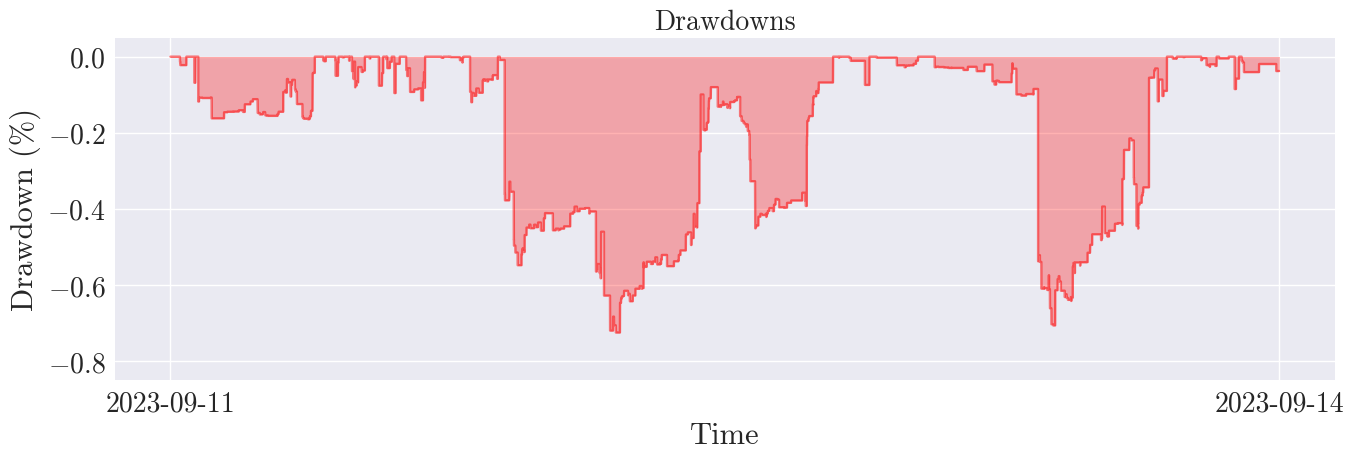

In [69]:
# AIRL - Load data
airl_data = results_airl[f"RL_prior_1_vol_100_{SEED_VISUAL}"]
airl_ts, airl_trader_stats, airl_initial_cost = (
    airl_data["timestamps"],
    airl_data["trader_stats"],
    airl_data["initial_cost"],
)

# AIRL - Plot P&L
path = fig_path("AIRL_seeds_pnl.pdf", SAVE_FIG)
title = r"P&L evolution" if PLOT_TITLE else None
make_plot(
    x=airl_ts,
    y=airl_trader_stats["adj_pnl"],
    title=title,
    xlabel="Time",
    ylabel="P&L (USDT)",
    save_path=path,
    loc_interval=1,
    figsize=FIG_SIZE,
)

# AIRL - Plot returns
airl_equity, airl_returns = compute_returns(
    airl_trader_stats, airl_initial_cost
)
path = fig_path("AIRL_seeds_returns.pdf", SAVE_FIG)
title = "Returns" if PLOT_TITLE else None
make_plot(
    x=airl_ts,
    y=airl_returns,
    title=title,
    xlabel="Time",
    ylabel="Returns (%)",
    save_path=path,
    loc_interval=1,
    figsize=FIG_SIZE,
)

# AIRL - Plot drawdowns
airl_dd = drawdowns(airl_equity)
path = fig_path("AIRL_seeds_drawdowns.pdf", SAVE_FIG)
title = "Drawdowns" if PLOT_TITLE else None
make_drawdown_plot(
    x=airl_ts,
    y=airl_dd,
    title=title,
    xlabel="Time",
    ylabel="Drawdown (%)",
    save_path=path,
    ylim=(-0.85, 0.05),
    figsize=FIG_SIZE,
)


# AIRL - Plot inventory
path = fig_path("AIRL_seeds_inventory.pdf", SAVE_FIG)
title = "Inventory evolution" if PLOT_TITLE else None
make_plot(
    x=airl_ts,
    y=airl_trader_stats["inventory"],
    title=title,
    xlabel="Time",
    ylabel="Inventory (SOL)",
    color="darkorange",
    save_path=path,
    loc_interval=1,
    figsize=FIG_SIZE,
)

# AIRL - Plot total traded volume
path = fig_path("AIRL_seeds_volume.pdf", SAVE_FIG)
title = "Cumulative traded volume" if PLOT_TITLE else None
make_plot(
    x=airl_ts,
    y=airl_trader_stats["total_volume"],
    title=title,
    xlabel="Time",
    ylabel="Traded volume (USDT)",
    color="darkorange",
    save_path=path,
    loc_interval=1,
    figsize=FIG_SIZE,
)

# AIRL - Plot cumulative transaction fees
path = fig_path("AIRL_seeds_fees.pdf", SAVE_FIG)
title = "Cumulative transaction fees" if PLOT_TITLE else None
make_plot(
    x=airl_ts,
    y=airl_trader_stats["cum_costs"],
    title=title,
    xlabel="Time",
    ylabel="Transaction fees (USDT)",
    color="red",
    save_path=path,
    loc_interval=1,
    figsize=FIG_SIZE,
)

if PRINT:
    print(f"Final P&L: {airl_trader_stats['adj_pnl'][-1]}")
    print()
    print("Returns stats")
    print(airl_returns.describe())
    print()
    print("Drawdown stats")
    print(airl_dd.describe())
    print()
    print("Inventory stats")
    print(pd.Series(airl_trader_stats["inventory"]).describe())
    print()
    print("Total volume:", airl_trader_stats["total_volume"][-1])
    print()
    print("Total fees:", airl_trader_stats["cum_costs"][-1])

Lastly, plot the comparison of the two strategies on joint plots.

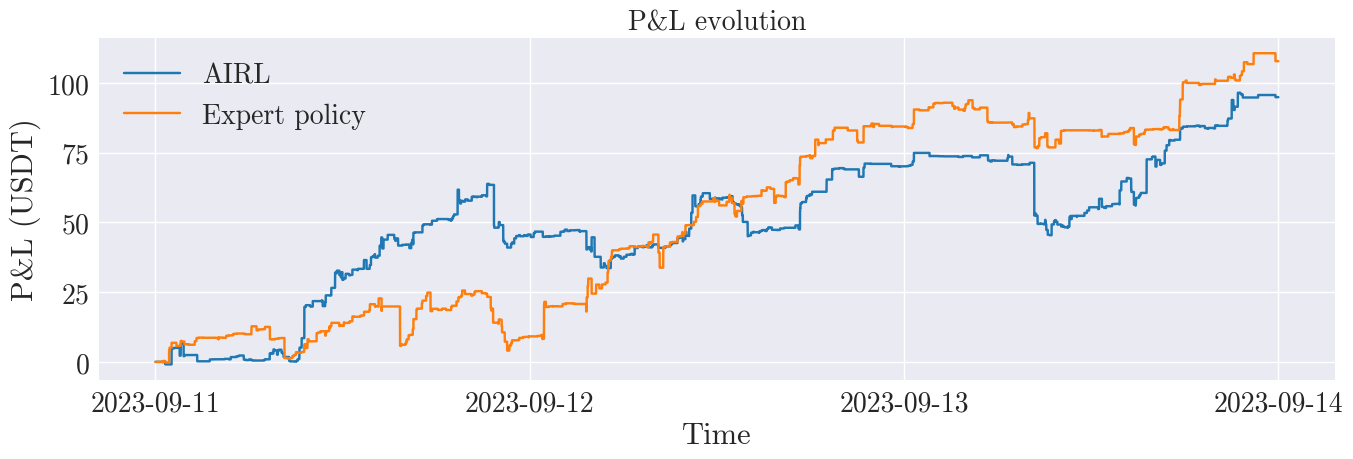

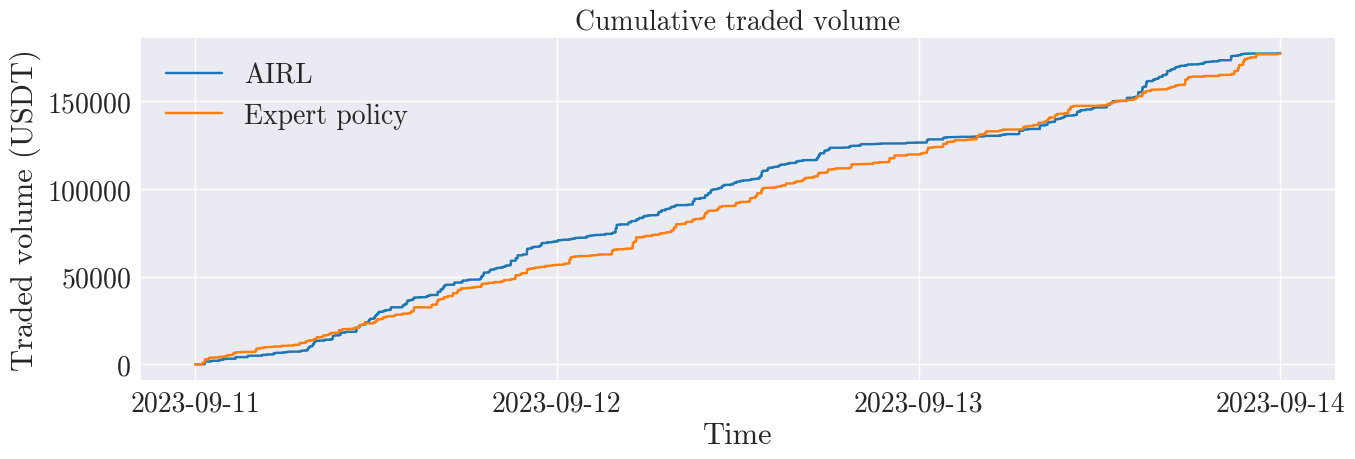

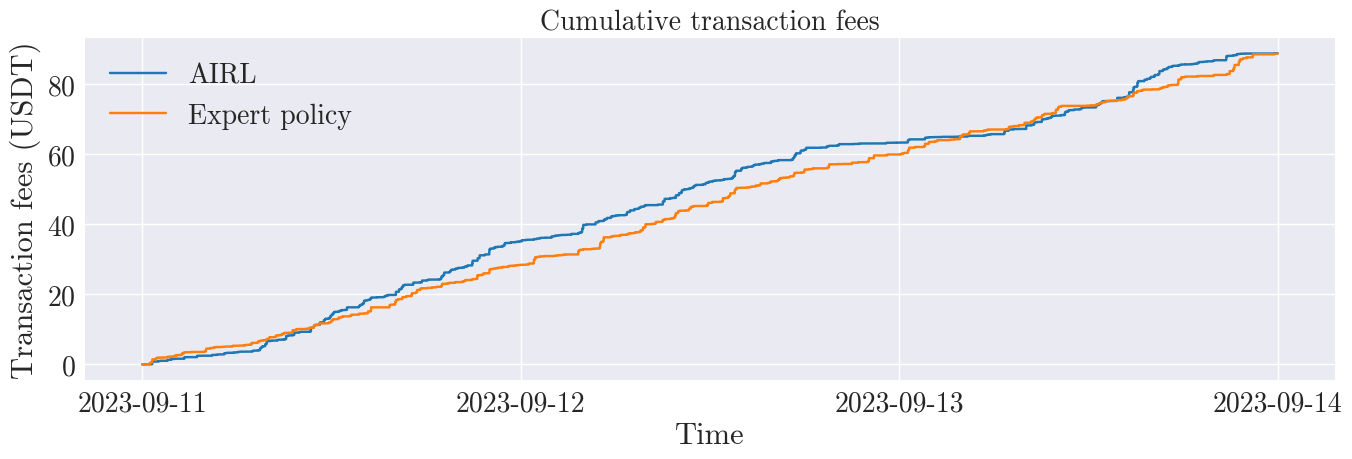

In [70]:
# Plot P&L
path = fig_path("comparison_seed_pnl.pdf", SAVE_FIG)
title = "P&L evolution" if PLOT_TITLE else None
plot_comparison(
    x_data_list=[airl_ts, pmm_ts],
    y_data_list=[airl_trader_stats["adj_pnl"], pmm_trader_stats["adj_pnl"]],
    labels=["AIRL", "Expert policy"],
    title=title,
    xlabel="Time",
    ylabel="P&L (USDT)",
    figsize=FIG_SIZE,
    save_path=path,
)

# Plot total traded volume
path = fig_path("comparison_seed_volume.pdf", SAVE_FIG)
title = "Cumulative traded volume" if PLOT_TITLE else None
plot_comparison(
    x_data_list=[airl_ts, pmm_ts],
    y_data_list=[
        airl_trader_stats["total_volume"],
        pmm_trader_stats["total_volume"],
    ],
    labels=["AIRL", "Expert policy"],
    title=title,
    xlabel="Time",
    ylabel="Traded volume (USDT)",
    figsize=FIG_SIZE,
    save_path=path,
)

# Plot transaction fees
path = fig_path("comparison_seed_fees.pdf", SAVE_FIG)
title = "Cumulative transaction fees" if PLOT_TITLE else None
plot_comparison(
    x_data_list=[airl_ts, pmm_ts],
    y_data_list=[airl_trader_stats["cum_costs"], pmm_trader_stats["cum_costs"]],
    labels=["AIRL", "Expert policy"],
    title=title,
    xlabel="Time",
    ylabel="Transaction fees (USDT)",
    figsize=FIG_SIZE,
    save_path=path,
)

This concludes the visualization of the backtest results.

# Section 7: Appendix (data analysis)

In this section, we provide additional data analysis of the pricing and trades data used in the training and backtesting of the market making strategies.

In [71]:
PRINT_APPENDIX = False  # Indicates whether to print more detailed statistics

## 7.1. Limit order book data

In this section, we provide additional data analysis of the limit order book data.

Firstly, load the limit order book data over the full period.

In [72]:
# Load all dataframes
dates = get_list_of_dates_between(DATE_START, DATE_END)
df = load_and_join_dataframes(dates, PATH)

# Compute the mid price and spreads (per limit order book level)
df["mid_price"] = (df["bid_0_price"] + df["ask_0_price"]) / 2
for i in range(3):
    df[f"spread_{i}"] = df[f"ask_{i}_price"] - df[f"bid_{i}_price"]

### 7.1.1. Visualize the mid-price

In this subsection, we plot the mid-price computed from the best bid and ask prices in the cleaned limit order book data.

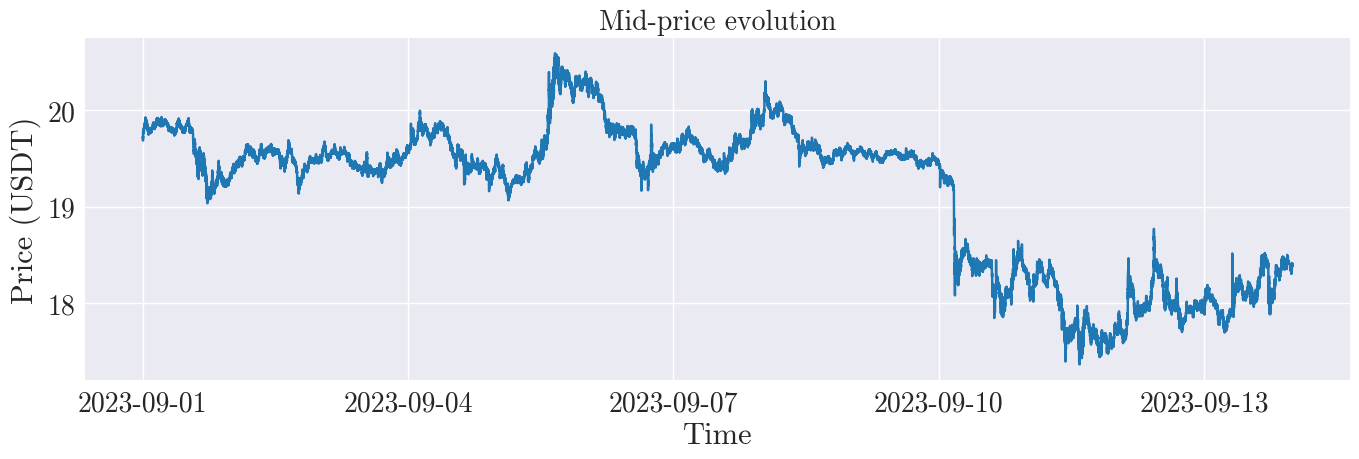

In [ ]:
# Plot the mid-price evolution over the whole period
plt.figure(figsize=FIG_SIZE)
plt.plot(df["mid_price"])
plt.xlabel("Time")
plt.ylabel("Price (USDT)")
if PLOT_TITLE:
    plt.title("Mid-price evolution")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, f"{SYMBOL}_mid_price.pdf"))
plt.show()

# Print the statistics for the mid-price
if PRINT_APPENDIX:
    print("Mid-price statistics:")
    print(df["mid_price"].describe())
    print()

### 7.1.2. Visualize the bid-ask spread

Next, we visualize the bid-ask spreads computed as the difference between the bid and ask prices on each limit order book level.

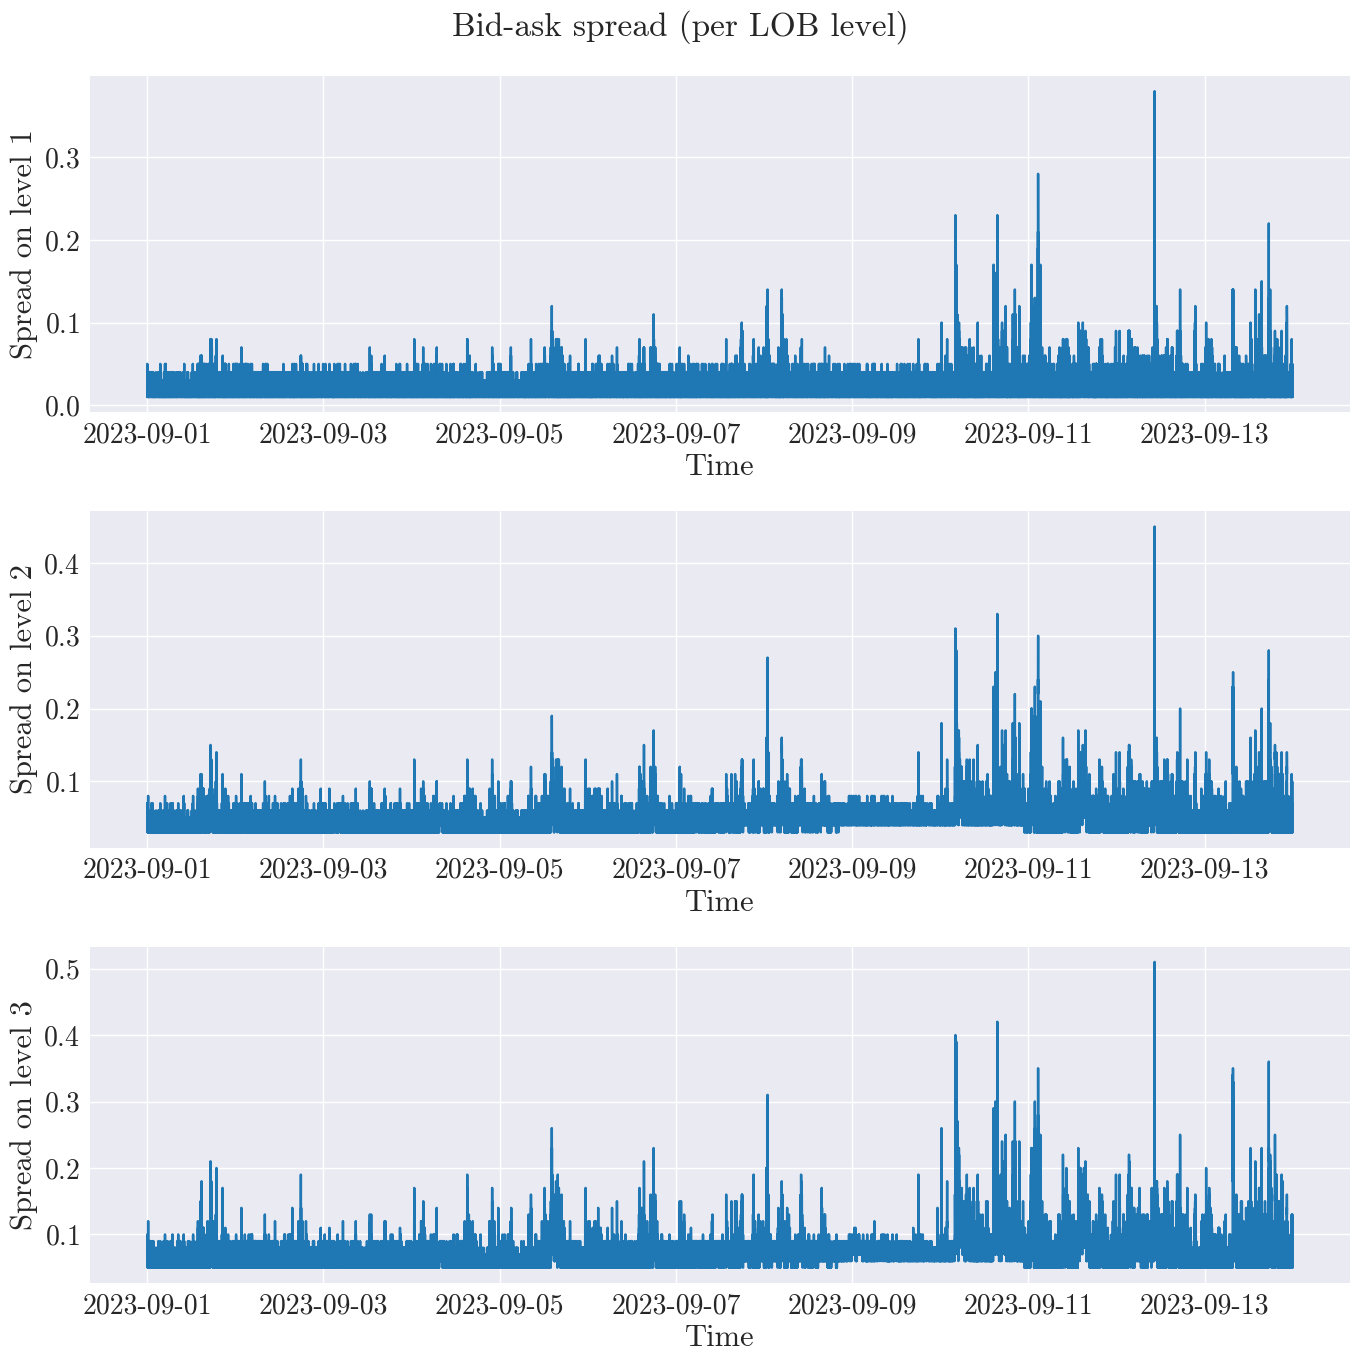

In [ ]:
# Plot bid-ask spreads (per limit order book level) evolution
fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], FIG_SIZE[0]), sharey=False)
if PLOT_TITLE:
    fig.suptitle("Bid-ask spread (per LOB level)")
for i in range(3):
    axs[i].plot(df[f"spread_{i}"])
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel(f"Spread on level {i+1}")
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_lob_spreads.pdf")
plt.show()

# Print statistics for bid-ask spreads
if PRINT_APPENDIX:
    for i in range(3):
        print(f"Spread on level {i+1}")
        print(df[f"spread_{i}"].describe())
        print()

### 7.1.3. Visualize the evolution and distribution of volumes

In this subsection, we visualize the evolution of volumes at each limit order book level and the distribution of volumes at each level.

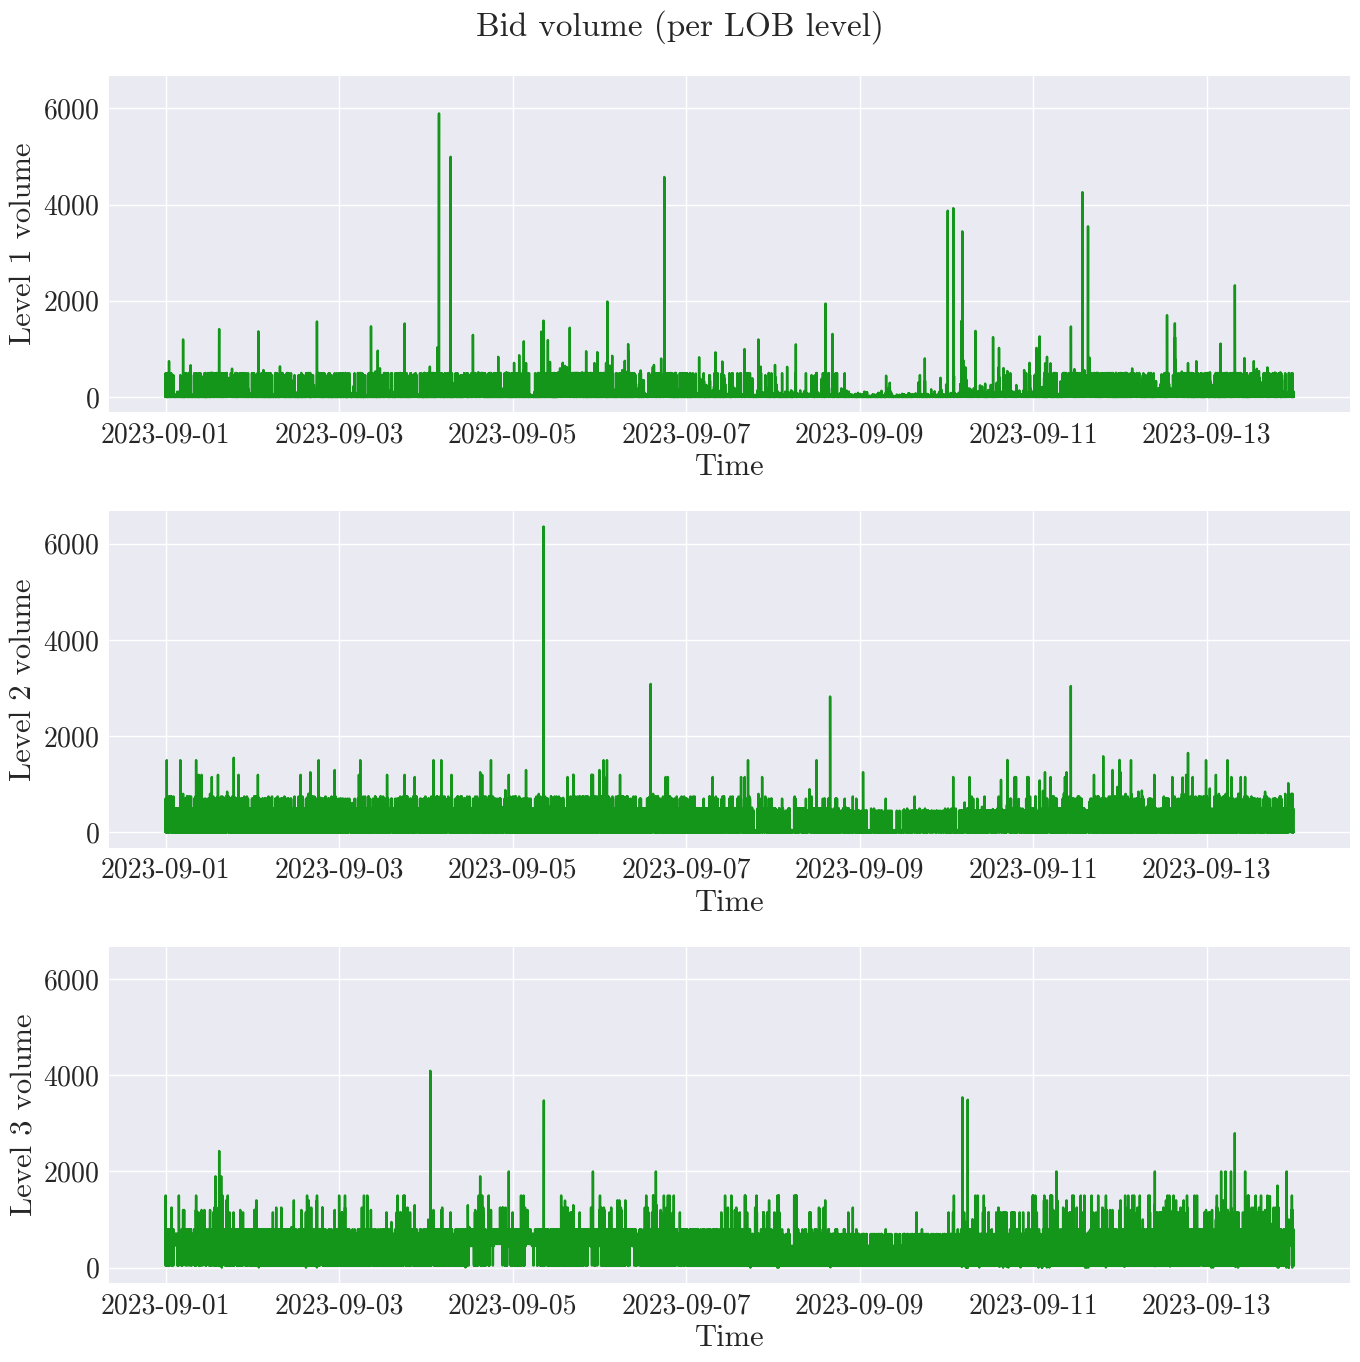

In [ ]:
# Plot volumes of the bid levels
fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], FIG_SIZE[0]), sharey=True)
if PLOT_TITLE:
    fig.suptitle("Bid volume (per LOB level)")
for i in range(3):
    axs[i].plot(df[f"bid_{i}_size"], color=COLOR_GREEN)
    axs[i].set_ylabel(f"Level {i+1} volume")
    axs[i].set_xlabel("Time")
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_lob_bid_volumes.pdf")
plt.show()

# Print statistics for bid volumes
if PRINT_APPENDIX:
    for i in range(3):
        print(f"Level {i} volume statistics")
        pd.options.display.float_format = "{:.3f}".format  # 3 decimal places
        print(df[f"bid_{i}_size"].describe())
        print()

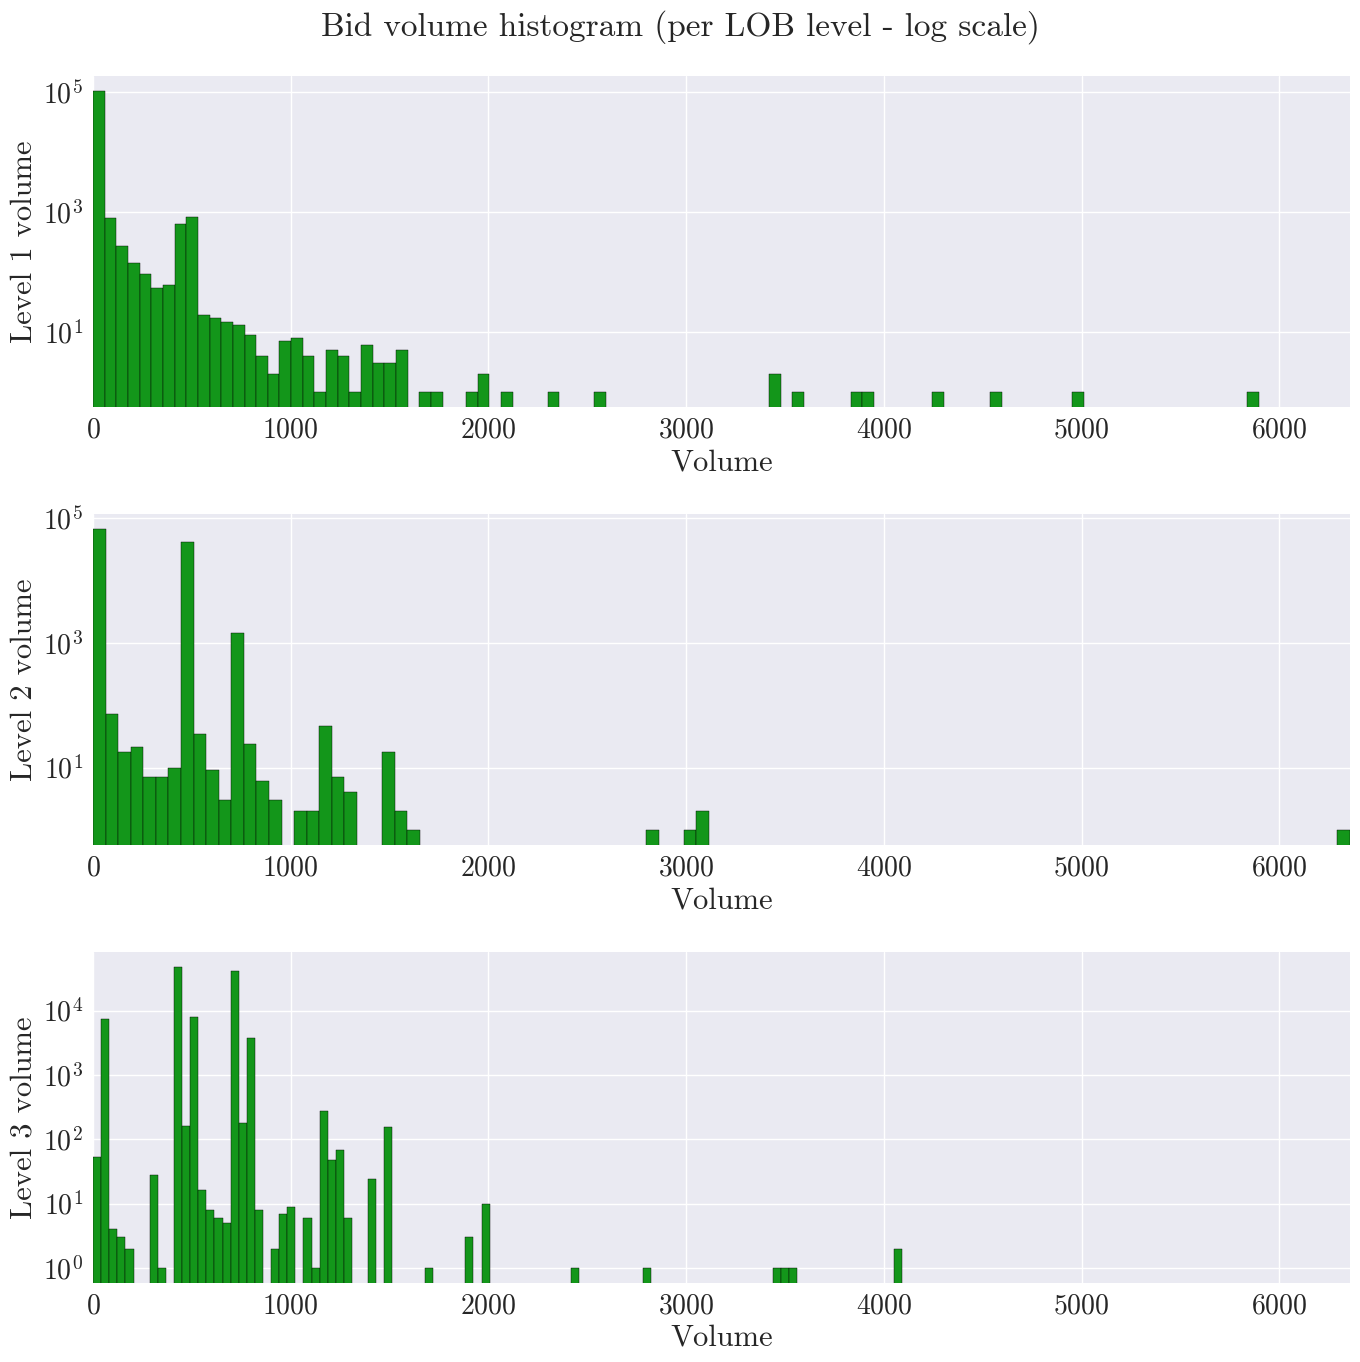

In [ ]:
# Plot histograms of bid volumes
fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], FIG_SIZE[0]))
if PLOT_TITLE:
    fig.suptitle("Bid volume histogram (per LOB level - log scale)")
for i in range(3):
    axs[i].hist(
        df[f"bid_{i}_size"],
        bins=100,
        edgecolor="black",
        log=True,
        color=COLOR_GREEN,
        linewidth=0.3,
    )
    axs[i].set_ylabel(f"Level {i+1} volume")
    axs[i].set_xlabel("Volume")

# Compute max volume for each level
max_volumes = [df[f"bid_{i}_size"].max() for i in range(3)]
max_volume = max(max_volumes)

# Set the same x-axis and bins  for all subplots
for i in range(3):
    axs[i].set_xlim(0, max_volume)

plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_lob_bid_volumes_hist.pdf")
plt.show()

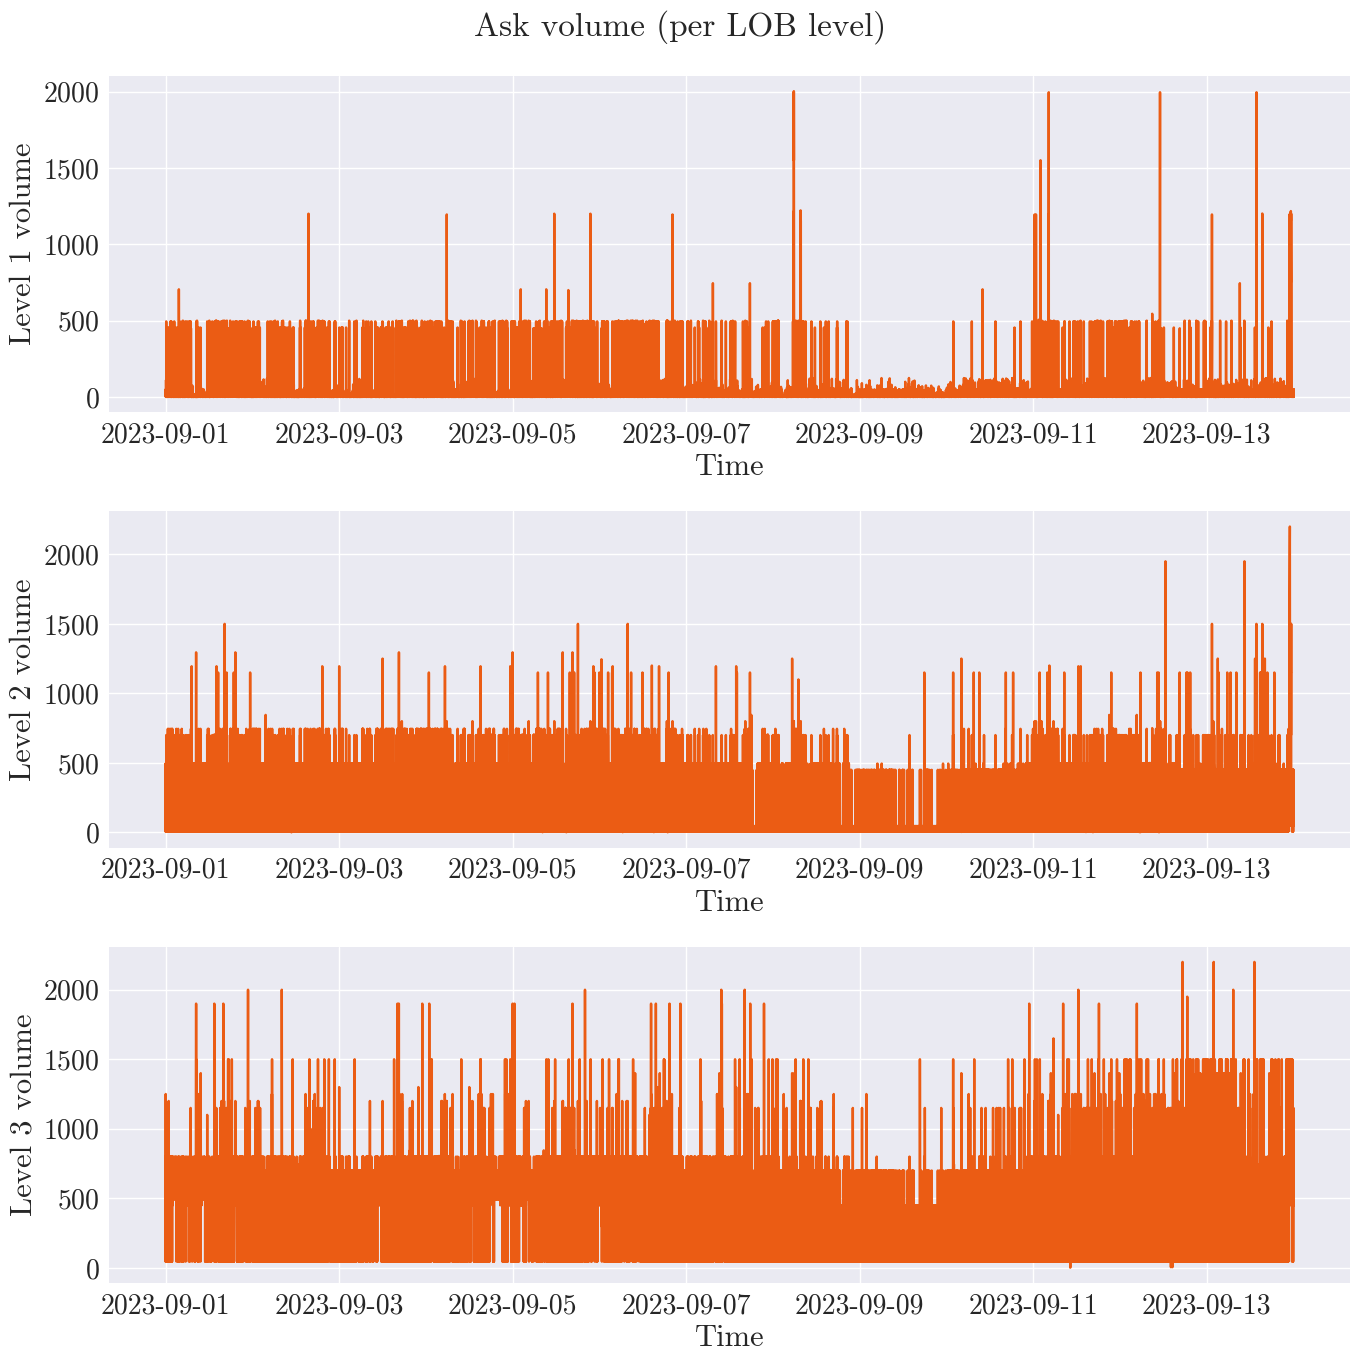

In [ ]:
# Create plot with five subfigures with the best ask volumes
fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], FIG_SIZE[0]))
if PLOT_TITLE:
    fig.suptitle("Ask volume (per LOB level)")
for i in range(3):
    axs[i].plot(df[f"ask_{i}_size"], color=COLOR_RED)
    axs[i].set_ylabel(f"Level {i+1} volume")
    axs[i].set_xlabel("Time")
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_lob_ask_volumes.pdf")
plt.show()

# Print statistics for ask volumes
if PRINT_APPENDIX:
    for i in range(3):
        print(f"Level {i} volume statistics")
        pd.options.display.float_format = "{:.3f}".format  # 3 decimal places
        print(df[f"ask_{i}_size"].describe())
        print()

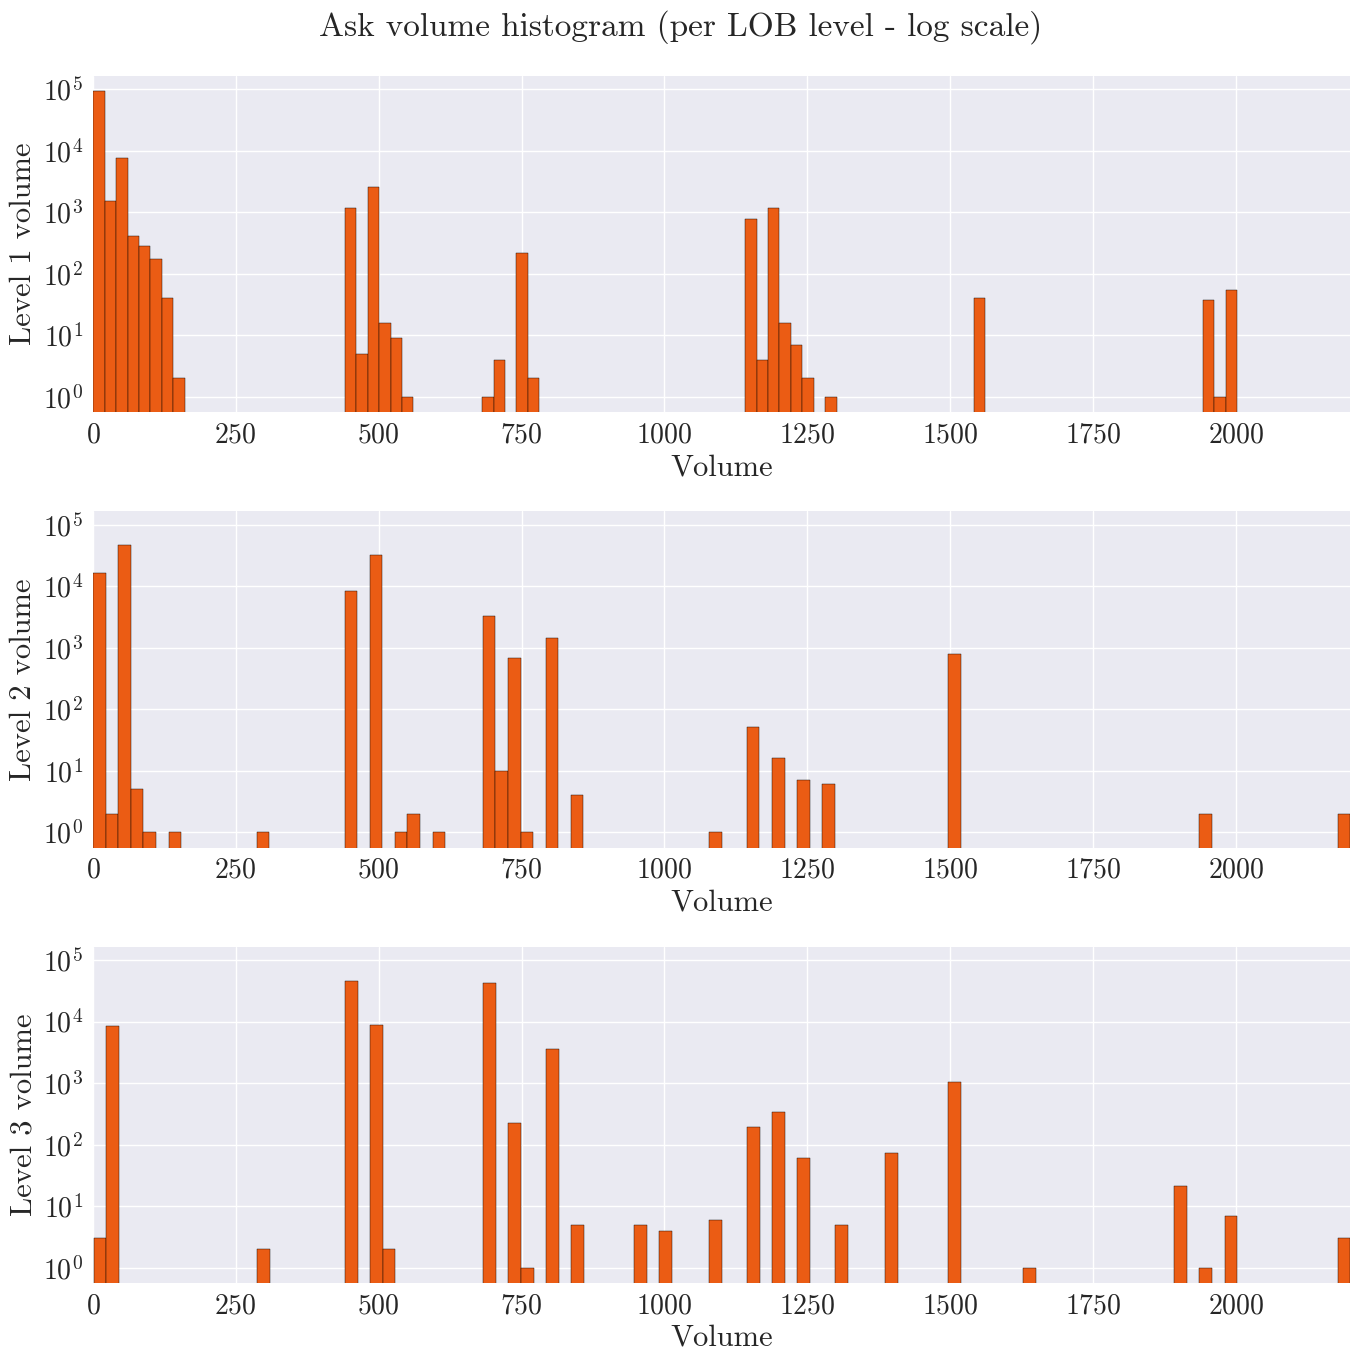

In [ ]:
# Plot histograms of ask volumes
fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], FIG_SIZE[0]), sharey=True)
if PLOT_TITLE:
    fig.suptitle("Ask volume histogram (per LOB level - log scale)")
for i in range(3):
    axs[i].hist(
        df[f"ask_{i}_size"],
        bins=100,
        edgecolor="black",
        log=True,
        color=COLOR_RED,
    )
    axs[i].set_ylabel(f"Level {i+1} volume")
    axs[i].set_xlabel("Volume")

# Compute max volume for each level
max_volumes = [df[f"ask_{i}_size"].max() for i in range(3)]
max_volume = max(max_volumes)

# Set the same x-axis and bins  for all subplots
for i in range(3):
    axs[i].set_xlim(0, max_volume)

plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_lob_ask_volumes_hist.pdf")
plt.show()

### 7.1.4. Visualize the order book imbalance

Lastly, we visualize the order book imbalance computed simply as the difference between the sum of volumes on the bid side and the sum of volumes on the ask side divided by the aggregated volume. In practice, filtering and smoothing methods should be analyzed to improve the signal-to-noise ratio of the order book imbalance signal.

In [79]:
# Set the time range for imbalance plots
ts_start_imb = datetime(2023, 9, 11, 9, 0, 0)
ts_end_imb = datetime(2023, 9, 11, 12, 0, 0)

In [80]:
# Compute the imbalance
df["bid_total_volume"], df["ask_total_volume"] = 0, 0
for i in range(20):
    temp_bid_size = df[f"bid_{i}_size"]
    temp_ask_size = df[f"ask_{i}_size"]
    temp_bid_size = temp_bid_size.fillna(0)
    temp_ask_size = temp_ask_size.fillna(0)
    df["bid_total_volume"] += temp_bid_size
    df["ask_total_volume"] += temp_ask_size
df["imbalance"] = (df["bid_total_volume"] - df["ask_total_volume"]) / (
    df["bid_total_volume"] + df["ask_total_volume"]
)

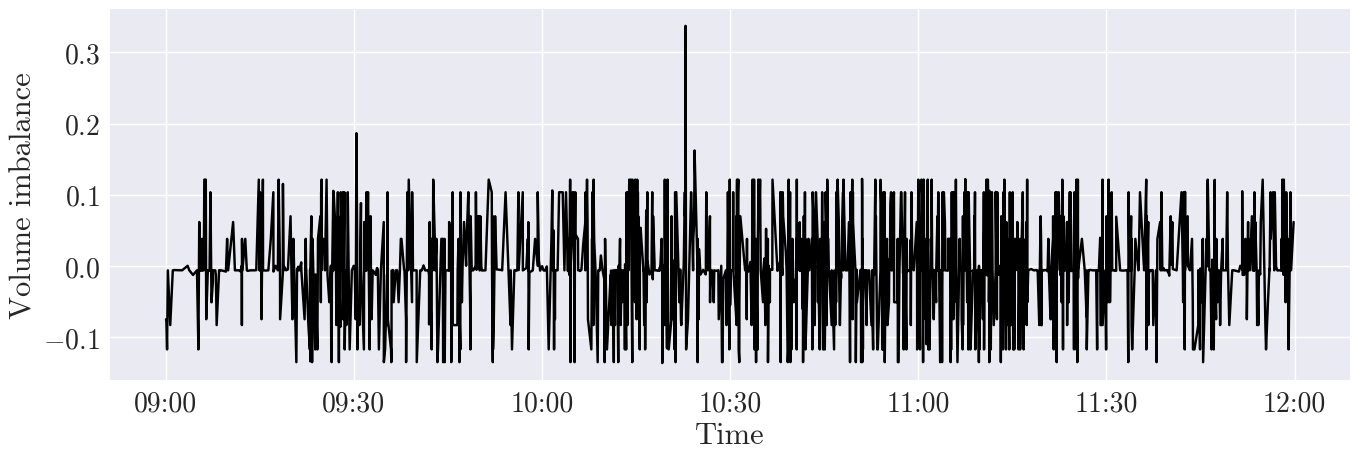

In [ ]:
# Plot imbalance evolution
fig = plt.figure(figsize=FIG_SIZE)
if PLOT_TITLE:
    plt.title("Order book imbalance evolution")
plt.plot(df["imbalance"][ts_start_imb:ts_end_imb], color="black")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel("Time")
plt.ylabel("Volume imbalance")
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_lob_volume_imbalance.pdf")
plt.show()

In [82]:
# Compute the imbalance signal for each limit order book level
for i in range(20):
    df[f"imbalance_{i}"] = (df[f"bid_{i}_size"] - df[f"ask_{i}_size"]) / (
        df[f"bid_{i}_size"] + df[f"ask_{i}_size"]
    )

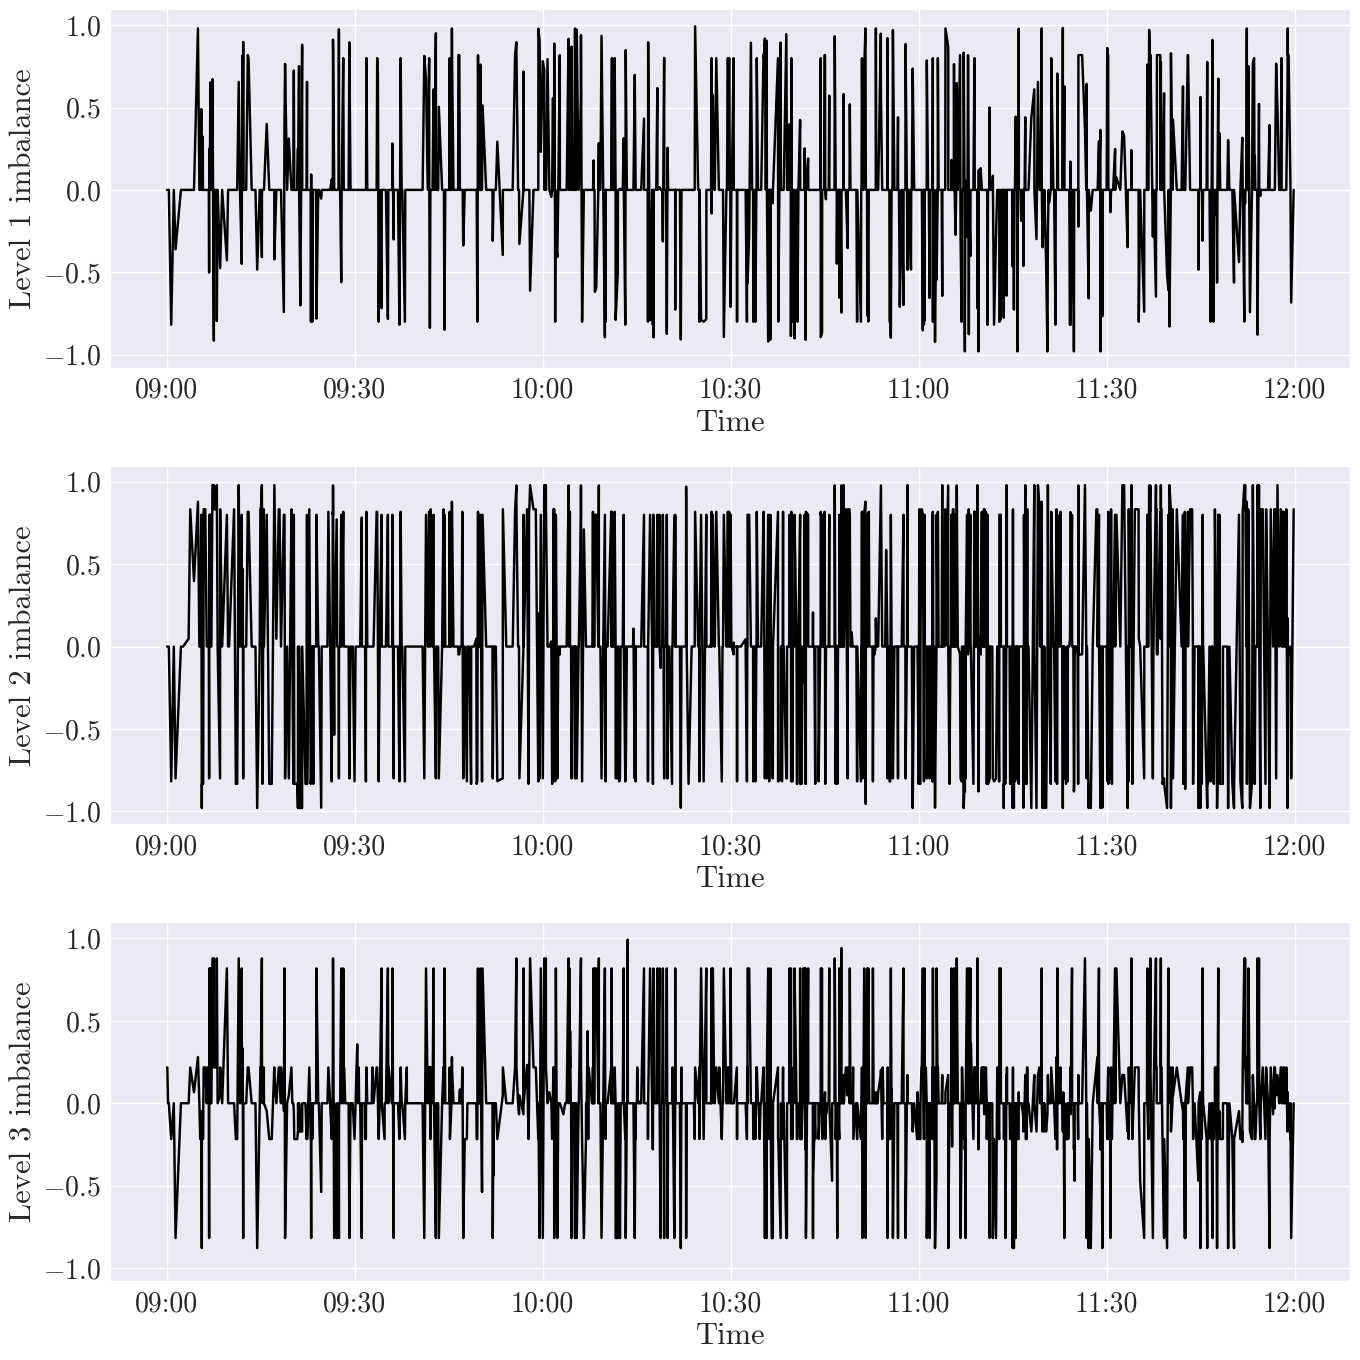

In [ ]:
# Plot the imbalance signal for top 5 levels
fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], FIG_SIZE[0]), sharey=True)
if PLOT_TITLE:
    fig.suptitle("Order book imbalance evolution (per LOB level)")
for i in range(3):
    axs[i].plot(df[f"imbalance_{i}"][ts_start_imb:ts_end_imb], color="black")
    axs[i].set_ylabel(f"Level {i+1} imbalance")
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[i].set_xlabel("Time")
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_lob_level_imbalance.pdf")
plt.show()

### 7.1.5. Visualize the order book snapshots

Lastly, in this section you can visualize the limit order book snapshots.

In [84]:
# Set the parameters for visualization
ts_orderbook = datetime(2023, 9, 9, 12, 0, 0)
depth = 6
length = 1

In [85]:
# Get the timestamps
all_timestamps = df.index

In [86]:
def find_first_index_larger_than(timestamp: datetime) -> int:
    """
    Find the index of the first timestamp that is larger than the given
    timestamp.
    """
    for i, ts in enumerate(all_timestamps):
        if ts > timestamp:
            return i

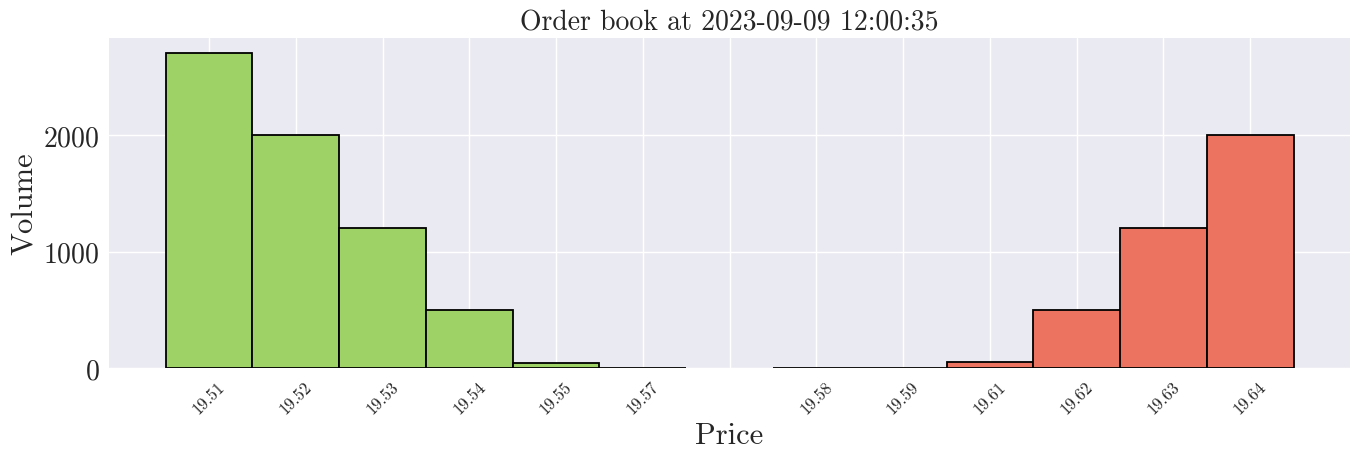

In [ ]:
# Visualize the order book snapshots
index = find_first_index_larger_than(ts_orderbook)
index_start = index
index_end = index_start + length

for i in range(index_start, index_end):
    ts = all_timestamps[i]
    bid_prices_labels = [f"bid_{i}_price" for i in range(depth)]
    ask_prices_labels = [f"ask_{i}_price" for i in range(depth)]
    bid_sizes_labels = [f"bid_{i}_size" for i in range(depth)]
    ask_sizes_labels = [f"ask_{i}_size" for i in range(depth)]

    # Process for one timestamp
    row = df.loc[ts]
    bid_prices = row[bid_prices_labels].to_numpy().flatten()
    ask_prices = row[ask_prices_labels].to_numpy().flatten()
    bid_volumes = row[bid_sizes_labels].to_numpy().cumsum()
    ask_volumes = row[ask_sizes_labels].to_numpy().cumsum()

    # X-axis
    spread_space = 1
    x_axis = np.arange(0, 2 * depth + spread_space, 1)

    # Plot the order book snapshot
    fig = plt.figure(figsize=FIG_SIZE)
    plt.bar(
        x_axis[:depth],
        bid_volumes[::-1],
        label="Bid",
        color="#9ED166",
        width=1,
        edgecolor="black",
        linewidth=1.3,
    )
    plt.bar(
        x_axis[depth + spread_space :],
        ask_volumes,
        label="Ask",
        color="#EB735F",
        width=1,
        edgecolor="black",
        linewidth=1.3,
    )
    x_ticks = np.append(bid_prices[::-1], ask_prices)
    x_ticks = np.insert(x_ticks, depth, "")
    plt.xticks(x_axis, x_ticks, rotation=45, size=12)

    if PLOT_TITLE:
        plt.title(f"Order book at {ts.strftime('%Y-%m-%d %H:%M:%S')}")
    plt.xlabel("Price")
    plt.ylabel("Volume")
    plt.tight_layout()
    if SAVE_FIG:
        ts_str = ts.strftime("%Y_%m_%d_%H_%M_%S")
        fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_lob_{ts_str}.pdf")
    plt.show()

## 7.2 Trade data analysis

### 7.2.1. Number of trades per day

In this subsection, we print the number of trades per day in the trade data.

In [88]:
# Load the trades data
dates = get_list_of_dates_between(DATE_START, DATE_END)
df = load_and_join_dataframes(dates, PATH, prefix=TRADES_PREFIX)

In [101]:
# Print number of trades per each date
avg_buy_volume, avg_sell_volume = 0, 0
avg_buy_orders, avg_sell_orders = 0, 0

for date in dates:
    file_name = f"{TRADES_PREFIX}_{date.strftime('%Y_%m_%d')}.parquet"
    df_single = pd.read_parquet(os.path.join(PATH, file_name))
    print(f"Statistics for date: {date.strftime('%Y-%m-%d')}")

    # Compute the number of buy and sell orders
    buy_orders = df_single[df_single["side"] == "buy"]
    sell_orders = df_single[df_single["side"] == "sell"]
    avg_buy_orders += buy_orders.shape[0]
    avg_sell_orders += sell_orders.shape[0]
    print(
        "Number of buy | sell orders: ",
        f"{buy_orders.shape[0]} | {sell_orders.shape[0]}",
    )

    # Compute the total volume of buy and sell orders
    buy_volume = buy_orders["quantity"].sum()
    sell_volume = sell_orders["quantity"].sum()
    avg_buy_volume += buy_volume
    avg_sell_volume += sell_volume
    print(
        "Total buy | sell volume: ",
        f"{round(buy_volume, 2)} SOL | {round(sell_volume, 2)} SOL",
    )

    # Compute the total volume
    total_volume = df_single["quantity"].sum()
    print()

# Compute the average number of buy and sell orders
avg_buy_orders /= len(dates)
avg_sell_orders /= len(dates)
print("-" * 50)
print(f"Average number of buy orders: {round(avg_buy_orders, 2)}")
print(f"Average number of sell orders: {round(avg_sell_orders, 2)}")

# Compute the average buy and sell volume
avg_buy_volume /= len(dates)
avg_sell_volume /= len(dates)
print(f"Average buy volume: {round(avg_buy_volume, 2)}")
print(f"Average sell volume: {round(avg_sell_volume, 2)}")

Statistics for date: 2023-09-01
Number of buy | sell orders:  3077 | 2795
Total buy | sell volume:  36739.66 SOL | 31546.31 SOL

Statistics for date: 2023-09-02
Number of buy | sell orders:  3050 | 2728
Total buy | sell volume:  27393.15 SOL | 21528.47 SOL

Statistics for date: 2023-09-03
Number of buy | sell orders:  3205 | 2920
Total buy | sell volume:  23255.01 SOL | 22639.8 SOL

Statistics for date: 2023-09-04
Number of buy | sell orders:  3007 | 2754
Total buy | sell volume:  31420.97 SOL | 28108.25 SOL

Statistics for date: 2023-09-05
Number of buy | sell orders:  2766 | 2669
Total buy | sell volume:  37750.92 SOL | 35421.06 SOL

Statistics for date: 2023-09-06
Number of buy | sell orders:  2826 | 2691
Total buy | sell volume:  40883.81 SOL | 38248.02 SOL

Statistics for date: 2023-09-07
Number of buy | sell orders:  2947 | 2401
Total buy | sell volume:  32193.51 SOL | 25356.52 SOL

Statistics for date: 2023-09-08
Number of buy | sell orders:  2989 | 2326
Total buy | sell volume:

### 7.2.2. Visualize buy and sell volumes throughout the day

Next, we visualize the buy and sell volumes in the trade data for a selected date.

In [90]:
# Select the date for visualization
date = dates[0]
print(f"Selected date: {date.strftime('%Y-%m-%d')}")

Selected date: 2023-09-01


In [91]:
# Load the trades data for the selected date
file_name = f"{TRADES_PREFIX}_{date.strftime('%Y_%m_%d')}.parquet"
df_single = pd.read_parquet(os.path.join(PATH, file_name))
buy_orders = df_single[df_single["side"] == "buy"]
sell_orders = df_single[df_single["side"] == "sell"]

In [92]:
# Plot hours only instead of full timestamps
date_format = DateFormatter("%H:%M")

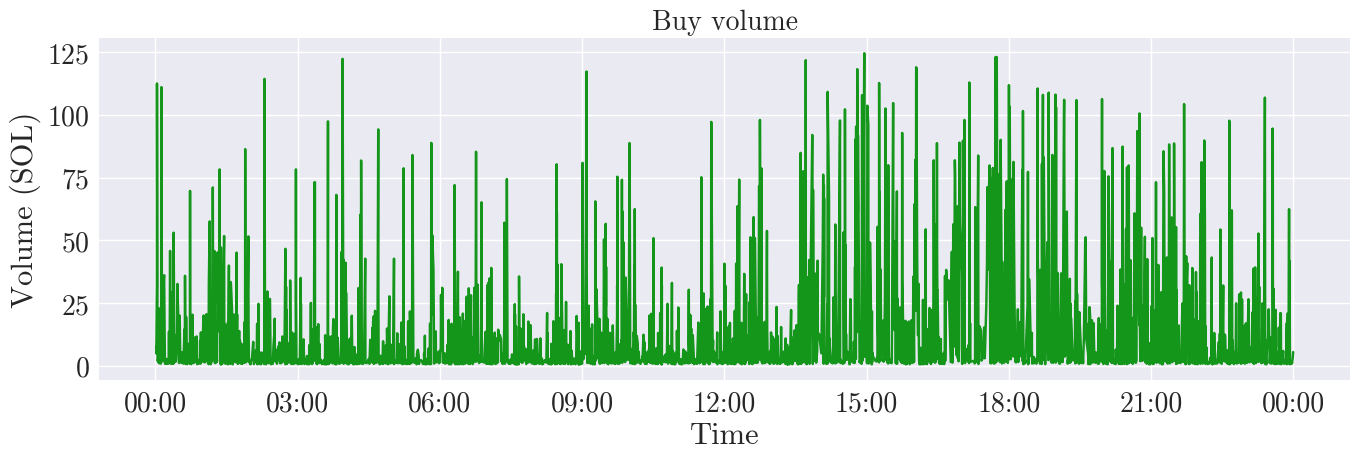

In [ ]:
# Visualize the buy volumes
fig = plt.figure(figsize=FIG_SIZE)
if PLOT_TITLE:
    plt.title("Buy volume")
plt.plot(buy_orders["received_time"], buy_orders["quantity"], color=COLOR_GREEN)
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Volume (SOL)")
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_buy_volume.pdf")
plt.show()

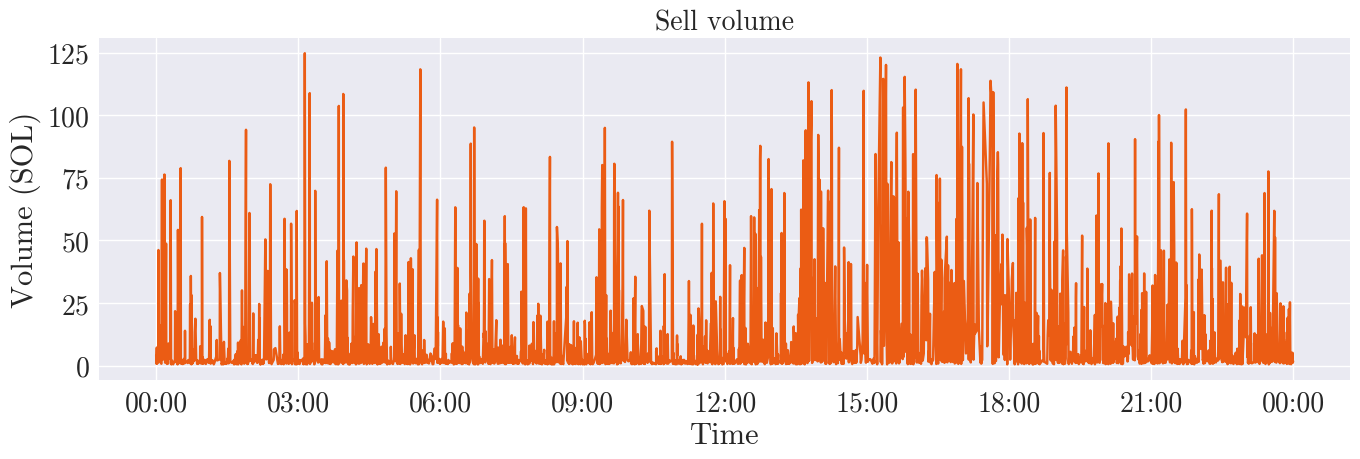

In [ ]:
# Visualize the sell volumes
fig = plt.figure(figsize=FIG_SIZE)
if PLOT_TITLE:
    plt.title("Sell volume")
plt.plot(sell_orders["received_time"], sell_orders["quantity"], color=COLOR_RED)
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Volume (SOL)")
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_sell_volume.pdf")
plt.show()

### 7.2.3. Visualize the distribution of trade sizes

In this subsection, we visualize the distribution of trade sizes in the trade data for a selected date from the previous subsection.

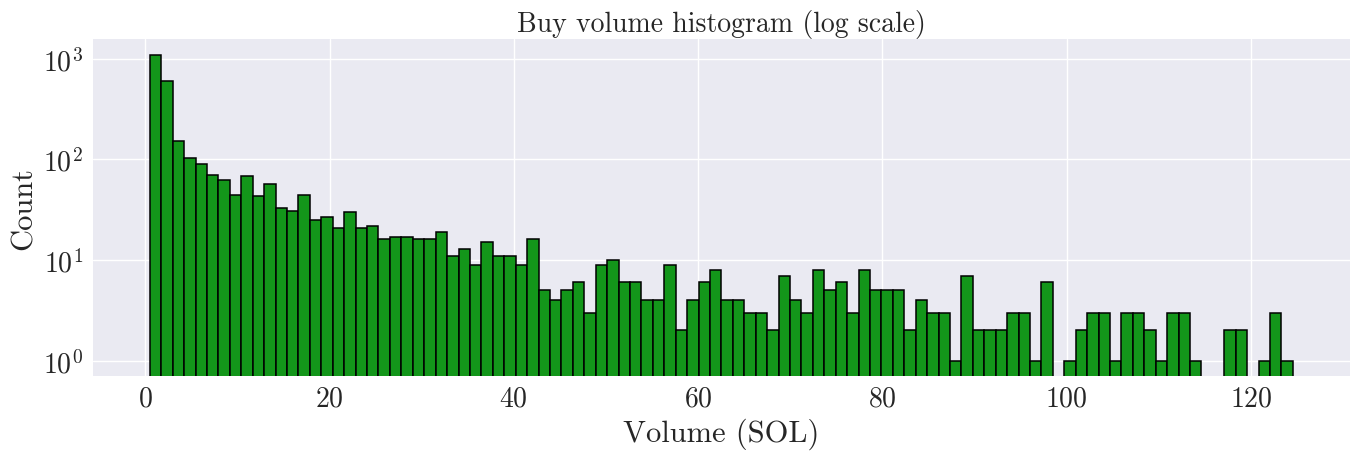

In [ ]:
# Plot the histogram of buy volumes
fig = plt.figure(figsize=FIG_SIZE)
if PLOT_TITLE:
    plt.title("Buy volume histogram (log scale)")
plt.hist(
    buy_orders["quantity"],
    bins=100,
    color=COLOR_GREEN,
    edgecolor="black",
    linewidth=1.1,
    log=True,
)
plt.xlabel("Volume (SOL)")
plt.ylabel("Count")
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_buy_volume_hist.pdf")
plt.show()

# Print the statistics for buy volumes
if PRINT_APPENDIX:
    print("Buy volume and price statistics:")
    print(buy_orders[["quantity", "price"]].describe())

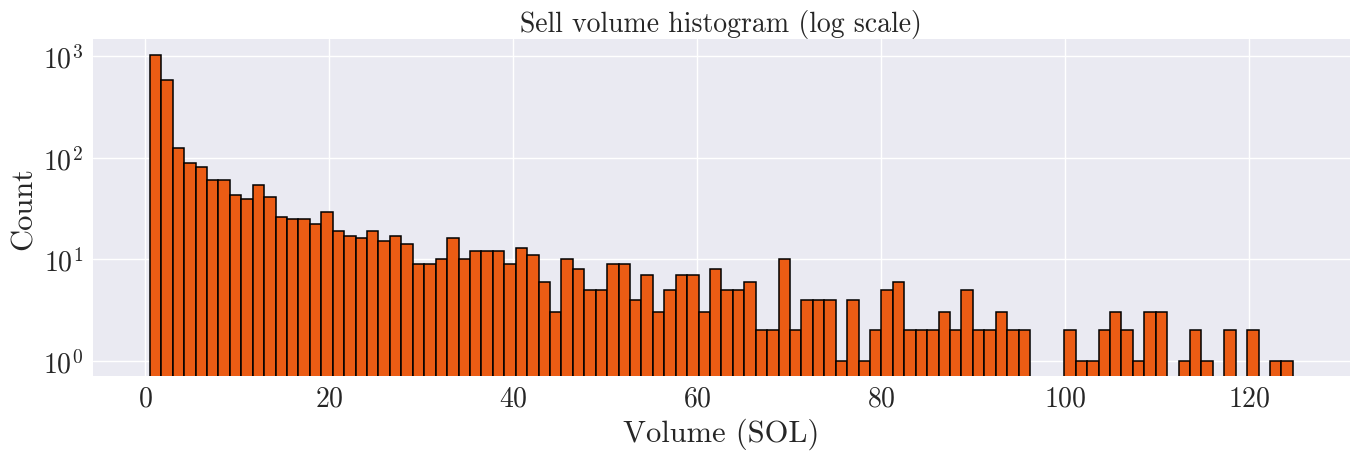

In [ ]:
# Plot the histogram of sell volumes
fig = plt.figure(figsize=FIG_SIZE)
if PLOT_TITLE:
    plt.title("Sell volume histogram (log scale)")
plt.hist(
    sell_orders["quantity"],
    bins=100,
    color=COLOR_RED,
    edgecolor="black",
    linewidth=1.1,
    log=True,
)
plt.xlabel("Volume (SOL)")
plt.ylabel("Count")
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_sell_volume_hist.pdf")
plt.show()

# Print statistics for sell volumes
if PRINT_APPENDIX:
    print("Sell volume and price statistics:")
    print(sell_orders[["quantity", "price"]].describe())

### 7.2.4. Visualize the trades imbalance

Lastly, we visualize the trades imbalance computed as the difference between the sum of buy and sell volumes divided by the sum of buy and sell volumes. As mentioned previously for the order book imbalance, in practice, you should analyze filtering and smoothing methods  to improve the signal-to-noise ratio of the trades imbalance signal.

In [97]:
# Select the date for visualization
date = dates[0]
print(f"Selected date: {date.strftime('%Y-%m-%d')}")

Selected date: 2023-09-01


In [98]:
# Load the trades data for the selected date
file_name = f"{TRADES_PREFIX}_{date.strftime('%Y_%m_%d')}.parquet"
df_single = pd.read_parquet(os.path.join(PATH, file_name))
buy_orders = df_single[df_single["side"] == "buy"]
sell_orders = df_single[df_single["side"] == "sell"]

# Resample the data to 1 minute intervals
buy_orders.set_index("received_time", inplace=True)
sell_orders.set_index("received_time", inplace=True)
buy_orders_1min = buy_orders["quantity"].resample("1min").sum()
sell_order_1min = sell_orders["quantity"].resample("1min").sum()

# Compute the order flow imbalance
eps = 1e-8
denominator = buy_orders_1min + sell_order_1min
denominator = denominator.replace(0, eps)
imbalance = (buy_orders_1min - sell_order_1min) / denominator

In [99]:
# Set the indices for the visualization
start_index = 720
end_index = 1080

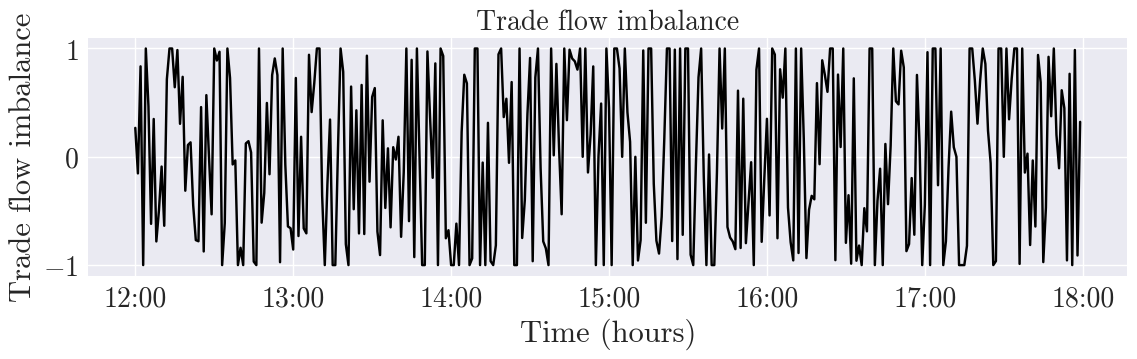

In [102]:
# Visualize the trade flow imbalance
fig = plt.figure(figsize=(12, 4))
plt.plot(imbalance[start_index:end_index], color="black")
if PLOT_TITLE:
    plt.title("Trade flow imbalance")
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Time (hours)")
plt.ylabel("Trade flow imbalance")
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{EXCHANGE}_{SYMBOL}_trade_flow_imbalance.pdf")
plt.show()

# Describe the order flow imbalance statistics
if PRINT_APPENDIX:
    print("Order flow imbalance statistics:")
    print(imbalance.describe())

This concludes the data analysis of the limit order book and trade data.